In [95]:
import numpy as np
import matplotlib.pyplot as plt
import codecs
import re
import os.path
import os
import nltk
import time
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from tqdm import tqdm
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")

# Données classification de sentiments (films)

## Chargement du petit jeu de données

In [86]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    list_dir = os.listdir(path2data)
    if '.DS_Store' in list_dir : list_dir.remove('.DS_Store')
    for cl in list_dir: # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


In [87]:
path = "./datasets/movies/movies1000/"
alltxts,alllabs = load_movies(path)
# Split the small dataset into training and testing sets
sX_train, sX_test, sY_train, sY_test = train_test_split(alltxts, alllabs, test_size=0.2, random_state=42)


## Chargement du grand jeu de données

In [6]:
import json
from collections import Counter

def split_list_of_tuples(lst):
    x = np.array([i[0] for i in lst])
    y = np.array([i[1] for i in lst])
    return x, y

# Loading json
with open("./datasets/movies/json_pol.json",encoding="utf-8") as f:
    data = f.readlines()
    json_data = json.loads(data[0])
    train = json_data["train"]
    test = json_data["test"]
    

# Quick Check
counter_train = Counter((x[1] for x in train))
counter_test = Counter((x[1] for x in test))
print("Number of train reviews : ", len(train))
print("----> # of positive : ", counter_train[1])
print("----> # of negative : ", counter_train[0])
print("")
print(train[0])
print("")
print("Number of test reviews : ",len(test))
print("----> # of positive : ", counter_test[1])
print("----> # of negative : ", counter_test[0])

print("")
print(test[0])
print("")


## Preparing the big dataset train and test 
X_train,Y_train = split_list_of_tuples(train)
X_test,Y_test = split_list_of_tuples(test)


Number of train reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

["The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it.", 1]

Number of test reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

['Although credit should have been given to Dr. Seuess for stealing the story-line of "Horton Hatches The Egg", this was a fine film. It touched both the emotions and the intellect. Due especially to the incredible performance of seven year old 

# A) Transformation paramétrique du texte (pre-traitements)

In [7]:
## Fonctions de base pour le pré-traitement et le nettoyage du texte

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as stopwords

import unicodedata
import string
import re

punc = string.punctuation  # recupération de la ponctuation
punc += '\n\r\t'

def lower(corpus, markers = []):
    """ Met le texte en minuscules sauf les mots correspondant aux marqueurs."""
    return [" ".join(word.upper() if word in markers else word.lower() for word in document.split()) for document in corpus]

def normalize(corpus):
    """ Suppression des accents et des caractères non normalisés """
    return [unicodedata.normalize('NFD', document).encode('ascii', 'ignore').decode("utf-8") for document in corpus]

def del_punc(corpus):
    """ Enlève les ponctuations."""
    return [document.translate(str.maketrans(punc, ' ' * len(punc))) for document in corpus]

def del_num(corpus):
    """ Enlève les chiffres."""
    return [re.sub('[0-9]+', '', document) for document in corpus] # remplacer une séquence de chiffres par rien

def mark_mulpunc(corpus, marker='MULPUNC'):
    """ Transformation des séquences de ponctuation en un marqueur spécifique (marker) """
    ponctuation = '[' + string.punctuation + ']{2,}'
    return [re.sub(ponctuation, ' ' + marker + ' ', txt) for txt in corpus]

def mark_mulmaj(corpus, marker='MULMAJ', n=5):
    """ On ne supprime pas les séquences complètement en majuscule, mais on les fait suivre d'un marqueur (marker)
        @return : str, txt transformé
    """
    marked_corpus = []
    
    for txt in corpus:
        all_maj = re.findall('[A-Z]+[A-Z0-9]{1,}', txt)
        for maj in all_maj:
            txt = re.sub(maj, maj + ' ' + 'MULMAJ ', txt)
            #txt = re.sub(maj,(maj + ' ') * n  + maj, txt)
        marked_corpus.append(txt)
    
    return marked_corpus

def stem(corpus, language):
    """ Racinisation des textes du corpus """
    # Stemmer dans la langue choisie
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    return [ ' '.join([ stemmer.stem(word) for word in txt.split() ]) for txt in corpus ]

def del_stopwords(corpus, language):
    """ Elimination des stopwords """
    # Liste des stopwords à supprimer (dans la langue choisie)
    stopwords_ = set(stopwords.words(language))
    return [ ' '.join([ word for word in txt.split() if word not in stopwords_ ]) for txt in corpus ]

def select_line(corpus, line=None):
    """ Fonction sélectionnant pour chaque texte du corpus:
            * l'intégralité du texte si line = None
            * la première ligne du texte si line = 0
            * la dernière ligne du texte si line = -1
        A noter que dans les données IMDb, chaque revue a pour dernière ligne ''.
    """
    if line != None:
        return [ txt.split('\n')[:-1][line] for txt in corpus ]
    return corpus

In [8]:
import copy

def text_processor(corpus, language, line=None, mark_punc=False, mark_maj=False, no_punc=False, no_num=False, lowercase=False, norm=False, no_stopwords=False, stemming=False):
    """ Processing paramétrique d'un corpus de texte (cf. chaîne de traitements ci-dessus).
        @param corpus: list(str), corpus de textes
        @param language: {'english', 'french'}
        @param line: {None, 0, -1}, paramètre line de la fonction select_line
        @param mark_mulpunc: {0,1}, vaut 1 si on applique la fonction mark_mulpunc
        @param mark_mulmaj: {0,1}, vaut 1 si on applique la fonction mark_mulmaj
        @param del_punc: {0,1}, vaut 1 si on applique la fonction del_punc
        @param del_num: {0,1}, vaut 1 si on applique la fonction del_num
        @param lower: {0,1}, vaut 1 si on applique la fonction lower
        @param normalize: {0,1}, vaut 1 si on applique la fonction normalize
        @param del_stopwords: {0,1}, vaut 1 si on applique la fonction del_stopwords
        @param stem: {0,1}, vaut 1 si on applique la fonction stem
        @return processed_corpus: list(str), corpus traité
    """
    # Récupération de la ponctuation
    punc = string.punctuation
    punc += '\n\r\t'
    
    # Multiplication multiple
    mulpunc = '[' + string.punctuation + ']{2,}'
    
    # Initialisation du stemmer
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    
    # Liste des stopwords à supprimer (dans la langue choisie)
    stopwords_ = set(stopwords.words(language))
    
    # Sélection de lignes si spécifié
    processed_corpus = select_line(copy.deepcopy(corpus), line=line)
    
    for i in range(len(processed_corpus)):
        text = processed_corpus[i]
        if mark_punc:
            text = re.sub(mulpunc, ' ' + 'MULPUNC' + ' ', text)
        if mark_maj:
            all_maj = re.findall('[A-Z]+[A-Z0-9]{1,}', text)
            for maj in all_maj:
                text = re.sub(maj, maj + ' ' + 'MULMAJ ', text)
        if no_punc:
            text = text.translate(str.maketrans(punc, ' ' * len(punc)))
        if no_num:
            text = re.sub('[0-9]+', '', text)
        if lowercase:
            markers = ['MULPUNC','MULMAJ']
            text = " ".join( word.upper() if word in markers else word.lower() for word in text.split() )
        if no_stopwords:
            text = ' '.join( word for word in text.split() if word not in stopwords_ )
        if norm:
            text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
        if stemming:
            text = ' '.join( stemmer.stem(word) for word in text.split() )
        processed_corpus[i] = text
    
    return np.array(processed_corpus)

# B) Extraction du vocabulaire (BoW)

## B.1. La taille originale du vocabulaire :

In [88]:
vectorizer = TfidfVectorizer()
X_embedded = vectorizer.fit_transform(sX_train)

# Affichage
vocabulaire = vectorizer.get_feature_names_out()
print('Taille vocabulaire = ', len(vocabulaire))

Taille vocabulaire =  36246


## B.2. Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]

In [89]:
from collections import Counter

def get_most_common_words(corpus, vocabulary, num_words=10):
    vocabulary = set(vocabulary) ## Convert vocabulary to set so that the membership checking can be done in constant time
    words = []
    for text in corpus:
        words.extend([word for word in text.split() if word in vocabulary])
    word_counts = Counter(words)
    return word_counts.most_common(num_words)

get_most_common_words(sX_train,vocabulaire)

[('the', 60979),
 ('and', 28275),
 ('of', 27135),
 ('to', 25426),
 ('is', 20100),
 ('in', 17257),
 ('that', 12102),
 ('it', 9951),
 ('as', 9101),
 ('with', 8568)]

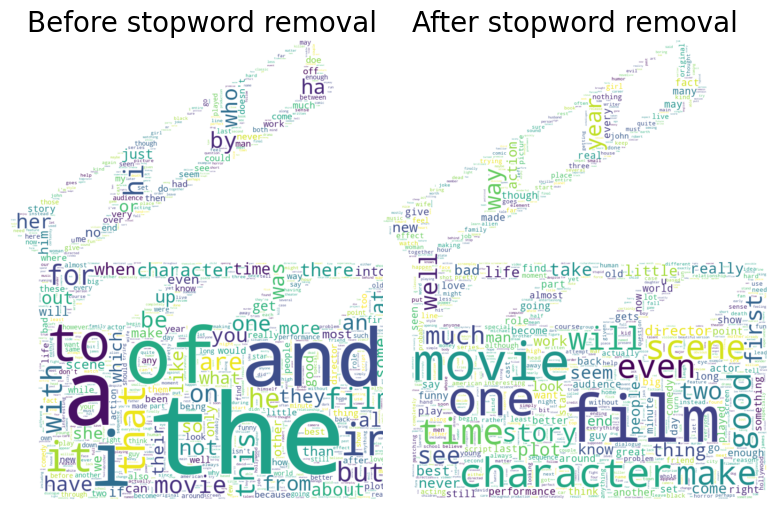

In [94]:
## Loading the mask image, just for fun and aesthetics
mask = np.array(Image.open("./mask.png"))

## Regrouping all movie reviews into one big review
text = ' '.join([document for document in sX_train])
# Generating the wordcloud without the use of stopwords
wc = WordCloud(background_color="white", max_words=1000, mask=mask,
               collocations=False, stopwords=[], contour_width=1, contour_color='white')
wc_before = wc.generate(text)

# Generating the wordcloud with the use of stopwords
wc = WordCloud(background_color="white", max_words=1000, mask=mask,
               collocations=False, stopwords=STOPWORDS, contour_width=1, contour_color='white')
wc_after = wc.generate(text)


# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wc_before, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("Before stopword removal", fontdict={'fontsize':20, 'y':1.1})
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wc_after, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("After stopword removal", fontdict={'fontsize':20, 'y':1.1})
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


### Remarques:
On peut remarquer que sans l'élimination des stopwords, la descriptivité et la significativé du wordcloud obtenu diminue fortement, à cause de la présence des mots les plus fréquents en anglais *(tel que the, and, to...)*. Ces mots ne décrivent pas notre jeu de données et ne vont servir à rien mis à part l'occupation inutile de l'espace dans le wordcloud. Le wordcloud obtenu après elimination des stopwords est plus déscriptif.

## B.3. Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]

Dans la classification des sentiments, le l'odds ratio est une mesure de l'association entre une caractéristique (par exemple, un mot) et une classe particulière (par exemple, un sentiment positif ou négatif). La formule de l'odds ratio est la suivante :

$$ \text{odds ratio(mot)} = \frac{p(\text{mot} | \text{positif})  *  (1 - p(\text{mot} | \text{negatif}))}{p(\text{mot} | \text{negatif})  *  (1 - p(\text{mot} | \text{positif}))} $$

où:

**p(mot|positif)** est la probabilité d'observer le mot étant donné que le sentiment est positif.

**p(mot|négatif)** est la probabilité d'observer le mot étant donné que le sentiment est négatif.

L'odds ratio nous indique combien il est plus probable que le mot apparaisse dans la classe positive par rapport à la classe négative. Si l'odds ratio est supérieur à 1, cela suggère que le mot est davantage associé à la classe positive, tandis que si l'odds ratio est inférieur à 1, cela suggère que le mot est  associé à la classe négative.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

def compute_odd_ratio(X, Y, eps=0.1,Vectorizer=None):
    """
    Calculates the odds ratio for each word in the corpus.
    If a word's odds ratio is > 1 : it is more likely from a positive reviews, otherwise it's from a negative one.
    
    Arguments:
        X: a list of documents, where each document is a string
        Y: a list of labels for each document in the corpus (Hypothesis that the labels are either 0 or 1)
        eps : Hyperparameter to avoid multiplying by a null probability while calculating odds ratio
        ngram_range : hyperparameter of the vectorizer
        Vectorizer : Type of vectorizer, by default it's TF-IDF, we can use CountVectorizer by passing by instanciating it and passing it in the parameter
    Returns:
        A dictionary of words in the corpus's vocabulary, each word is associated with its odds ratio
    """
    X_0 = [X[i] for i in range(len(X)) if Y[i] == 0] ## negative reviews
    X_1 = [X[i] for i in range(len(X)) if Y[i] == 1] ## positive reviews
        
    ## Extract vocabulary of negative reviews and the frequency of each word used
    if Vectorizer is None : vectorizer_0 = TfidfVectorizer()
    else : vectorizer_0 = Vectorizer
    x_0 = vectorizer_0.fit_transform(X_0)
    voc_0 = vectorizer_0.get_feature_names_out()
    word_counts_0 = {}
    for i, word in enumerate(voc_0):
        word_counts_0[word] = x_0[:, i].sum()
    
    ## Extract vocabulary of positive reviews and the frequency of each word used
    if Vectorizer is None : vectorizer_1 = TfidfVectorizer()
    else : vectorizer_1 = Vectorizer
    x_1 = vectorizer_1.fit_transform(X_1)
    voc_1 = vectorizer_1.get_feature_names_out()
    word_counts_1 = {}
    for i, word in enumerate(voc_1):
        word_counts_1[word] = x_1[:, i].sum()
    
    ## Calculate global vocabulary without having to fit a Count Vectorizer to the entire corpus
    voc_global = list(set(voc_0) | set(voc_1))
    
    
    # Calculate the total number of occurrences of each word in each class
    total_word_count_0 = sum(word_counts_0.values())
    total_word_count_1 = sum(word_counts_1.values())
    
    # Calculate term frequency for each class
    prob_word_0 = {word: word_counts_0.get(word,0) / total_word_count_0 for word in voc_global}
    prob_word_1 = {word: word_counts_1.get(word,0) / total_word_count_1 for word in voc_global}

    
    # Calculate the odds ratio for each word
    odds_ratio = {word : (prob_word_1[word] * (1 - prob_word_0[word]) + eps) / ( prob_word_0[word] * (1 - prob_word_1[word]) + eps) for word in voc_global}
    return odds_ratio
    

def visualize_class_wordcloud(odds_ratio, label, n, language='english', mask=None,show=True) :
    """
        Visualize a wordcloud for the given label (0 : negative, 1 : positive) given the odds ratio calculated for 
        each word in the corpus.
    Arguments:
        odds_ratio: A dictionary of words in the corpus's vocabulary, each word is associated with its odds ratio
        label: 0 for negative reviews, 1 for positive reviews.
        n : Maximum number of words in the wordcloud
        language : used to generate the stopwords passed to the wordcloud
        mask : used for the wordcloud mask as a visual aesthetic
        show : the calculated wordcloud is shown if True, otherwise, it won't be. True by default.
    
    Returns:
        The wordcloud corresponding to the label passed as an argument.
    """
    #stopwords_list = set(stopwords.words(language))
    stopwords_list = []

    if label == 1 : ## we generate the cloud for negative reviews, green color palette chosen
        sorted_ratios = dict(sorted(odds_ratio.items(), key=lambda item: item[1], reverse=True))
        ratios_dict = {word : sorted_ratios[word] for word in list(sorted_ratios.keys())[:n]}
        wc = WordCloud(background_color="white", max_words=n, mask=mask, collocations=False, stopwords=stopwords_list, colormap='viridis',contour_width=0, contour_color='white')
        
    else : ## we generate the cloud for negative reviews, reddish color palette chosen
        sorted_ratios = dict( sorted(odds_ratio.items(), key=lambda item: item[1], reverse=False))
        ratios_dict = {word : 1/sorted_ratios[word] for word in list(sorted_ratios.keys())[:n]}

        wc = WordCloud(background_color="white", max_words=n, mask=mask, collocations=False, stopwords=stopwords_list, colormap='magma',contour_width=0, contour_color='white')

        
    wc = wc.generate_from_frequencies(ratios_dict)

    # Visualization
    if show : 
        plt.figure(figsize = (15,10))
        plt.imshow(wc)
        plt.axis("off")
        plt.show()
        
    return wc

In [19]:
## pre-processing data by activating : removing punctuation, removing numbers, lower-casing, removing stopwords, normalizing, stemming
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the dataset
cv = CountVectorizer()
odds_ratio = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=cv)

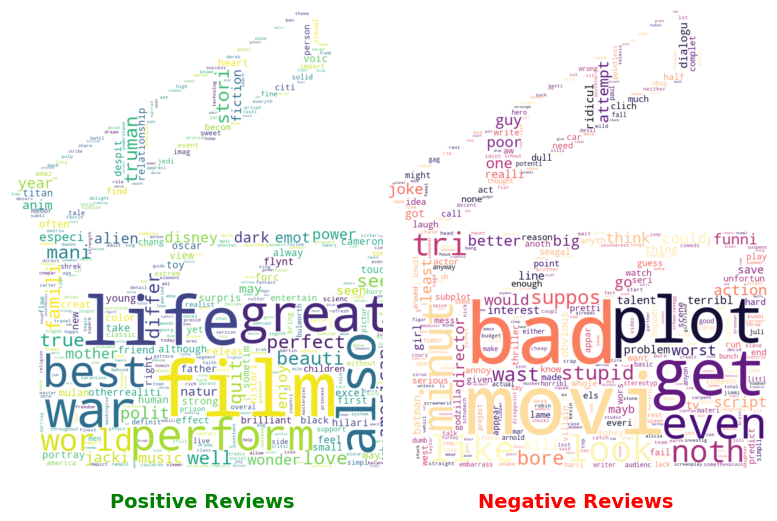

In [20]:
## Positive reviews wordcloud
wordcloud_1 = visualize_class_wordcloud(odds_ratio,1,400,language='english',mask=mask,show=False)

## Negative reviews wordcloud
wordcloud_0 = visualize_class_wordcloud(odds_ratio,0,400,language='english',mask=mask,show=False)


# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_1, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("Positive Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'green'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_0, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("Negative Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'red'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


## B.4. Quelle est la distribution d'apparition des mots (Zipf) ?

Selon la loi de Zipf, dans une langue naturelle, les mots les plus fréquemment utilisés ont une fréquence d'utilisation beaucoup plus élevée que les mots les moins fréquemment utilisés. De plus, la fréquence relative d'utilisation des mots est inversement proportionnelle à leur rang dans la liste des mots classés par fréquence d'utilisation. Autrement dit, le deuxième mot le plus fréquemment utilisé aura une fréquence d'utilisation environ deux fois plus faible que le mot le plus fréquemment utilisé, le troisième mot aura une fréquence d'utilisation environ trois fois plus faible que le mot le plus fréquemment utilisé, et ainsi de suite.

La loi de Zipf peut être représentée par une courbe log-log, où la fréquence relative d'utilisation des mots est représentée sur l'axe des y, et leur rang sur l'axe des x. La courbe est généralement proche d'une droite, ce qui montre que la relation entre la fréquence d'utilisation et le rang est presque linéaire.

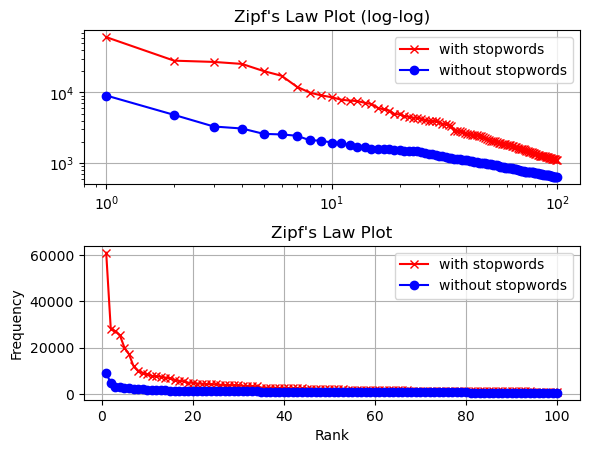

In [21]:
import matplotlib.pyplot as plt
import numpy as np

mcw_with_stopwords = get_most_common_words(sX_train,vocabulaire) ## red color
mcw_without_stopwords = get_most_common_words(sX_train_processed,vocabulaire) ## blue color

# Plotting distribution of words before and after removal of stopwords
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
words = [word_count[0] for word_count in mcw_with_stopwords]
freqs = [word_count[1] for word_count in mcw_with_stopwords]
words2 = [word_count[0] for word_count in mcw_without_stopwords]
freqs2 = [word_count[1] for word_count in mcw_without_stopwords]
rank = np.arange(1, len(words)+1)
rank2 = np.arange(1, len(words)+1)
plt1, = ax1.loglog(rank, freqs, label = "with stopwords", color="red", marker="x") 
plt2, = ax1.loglog(rank2, freqs2, label = "without stopwords", color="blue", marker="o")
ax1.set_title("Zipf's Law Plot (log-log)")
ax1.legend(handles=[plt1, plt2],loc = "upper right")
ax1.grid(True)
plt1, = ax2.plot(rank, freqs, label = "with stopwords", color="red", marker="x") 
plt2, = ax2.plot(rank2, freqs2, label = "without stopwords", color="blue", marker="o")
ax2.set_title("Zipf's Law Plot")
ax2.grid(True)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend(handles=[plt1, plt2],loc = "upper right")
plt.subplots_adjust(hspace=0.4)
plt.show()

## B.5. Quels sont les 100 bigrammes/trigrammes les plus fréquents?

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def get_top_ngrams(texts,ngram_range,topk=100):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    ngram_counts = dict(zip(feature_names, X.toarray().sum(axis=0)))
    top_k_ngrams = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:topk]
    return top_k_ngrams

In [23]:
## Calculating the top 100 bigrams
top_100_bigrams = get_top_ngrams(sX_train_processed,(2,2))

## Calculating the top 100 trigrams
top_100_trigrams = get_top_ngrams(sX_train_processed,(3,3))

In [28]:
print("TOP 10 BIGRAMS AND THEIR RESPECTIVE FREQUENCIES : ")
for i in range(10)  : print(top_100_bigrams[i])


print("\nTOP 10 BIGRAMS AND THEIR RESPECTIVE FREQUENCIES : ")
for i in range(10)  : print(top_100_trigrams[i])

TOP 10 BIGRAMS AND THEIR RESPECTIVE FREQUENCIES : 
('special effect', 317)
('look like', 251)
('year old', 186)
('even though', 179)
('new york', 168)
('seem like', 164)
('high school', 156)
('star war', 156)
('film like', 152)
('bad guy', 149)

TOP 10 BIGRAMS AND THEIR RESPECTIVE FREQUENCIES : 
('know last summer', 58)
('save privat ryan', 46)
('tommi lee jone', 37)
('new york citi', 35)
('blair witch project', 32)
('scienc fiction film', 29)
('saturday night live', 28)
('jay silent bob', 25)
('wild wild west', 25)
('film take place', 24)


On peut déja commencer a remarquer que l'inclusion des bi-grammes dans le vocabulaire du corpus ajoute de la sémantique et du sens. Dans le cas oû on utilise que des mots unaire, on se retrouve avec pas mal de mots qui décrivent les sentiments de la personne qui rédige, mais il existe un nombre important de mots qui ne décrivent pas les sentiments s'ils sont présentés en forme de 1-gramme ou Bi-gramme, par exemple :

- **"Movie" VS "Bad Movie" :** le mot "Movie" ne permet pas de dire si la personne qui a redigé le review aime le film ou non, contrairement à Bad Movie.
- **"One" VS "One Best" :** le mot "One" ne permet pas de dire si la personne qui a redigé le review aime le film ou non, contrairement à "One Best" qui correspond à "One of the Best" après la suppression des stopwords "the" et "of".

Avec les tri-grammes, on obtient encore plus de détails sur les reviews, tel que les noms trigrammes des films et les noms des acteurs associés à ces films. Il est à noter que ce n'est pas nécessairement une bonne chose. La classification des sentiments doit rester assez générale pour éviter de tomber dans le piège du surapprentissage. 

**Essayons de recalculer le dictionnaire de odds_ratio en prenant comme vocabulaire les bigrammes et les trigrammes cette fois-ci**

**REMARQUE : le temps de calcul peut être très très long, à cause de l'explosion de la taille du vocabulaire**

In [33]:
## pre-processing data by activating : removing punctuation, removing numbers, lower-casing, removing stopwords, normalizing, stemming
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the dataset, by including bigrams only in the vocabulary
cv = CountVectorizer(ngram_range=(2,2))
start = time.time()
odds_ratio_bigrams = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=cv)
print('Time elapsed: ', time.time() - start)

Time elapsed:  11.825483083724976


In [436]:
print("Taille du dictionnaire composé des mots d'unité seulement : ", len(odds_ratio))
print("Taille du dictionnaire composé des bi-grammes seulement : ", len(odds_ratio_bigrams))

print("La taille du vocabulaire est " + f"{round(len(odds_ratio_bigrams)/len(odds_ratio))}" + " fois plus grande.")

Taille du dictionnaire composé des mots d'unité seulement :  22835
Taille du dictionnaire composé des bi-grammes seulement :  398547
La taille du vocabulaire est 17 fois plus grande.


On remarque que la taille du vocabulaire explose très rapidement. Cela peut conduire à du sur-apprentissage car le nombre des features (dimensions) obtenues est beaucoup plus grand que le nombre d'exemples qu'on a dans le dataset, et cela est en utilisant seulement les bigrammes, avec les bigrammes + unigrammes ça sera encore pire. La solution est de limiter la taille du vocabulaire avec le paramètre **'max_features'**

Réessayons la vectorisation avec un ngram_range(1,2) et un seuil max de la taille du vocabulaire.

Time elapsed:  23.20650005340576
Taille du dictionnaire composé des mots d'unité seulement :  22789
Taille du dictionnaire composé des bi-grammes et uni-grammes :  13449
La taille du vocabulaire est 1 fois plus grande.


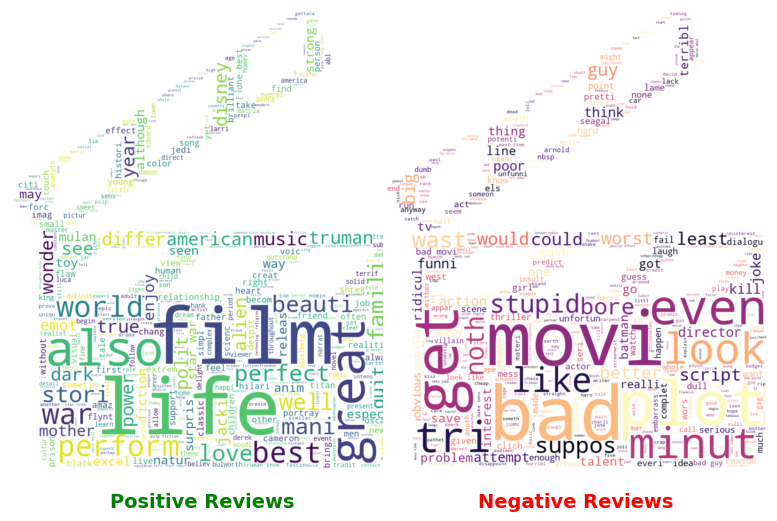

In [35]:
## Calculating the odds ratio of the dataset, by including unigrams and bigrams in the vocabulary
cv = CountVectorizer(ngram_range=(1,2),max_features=10000)
start = time.time()
odds_ratio_enhanced = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=cv)
print('Time elapsed: ', time.time() - start)

print("Taille du dictionnaire composé des mots d'unité seulement : ", len(odds_ratio))
print("Taille du dictionnaire composé des bi-grammes et uni-grammes : ", len(odds_ratio_enhanced))

print("La taille du vocabulaire est " + f"{round(len(odds_ratio_enhanced)/len(odds_ratio))}" + " fois plus grande.")


## Positive reviews wordcloud
wordcloud_1 = visualize_class_wordcloud(odds_ratio_bigrams,1,400,language='english',mask=mask,show=False)

## Negative reviews wordcloud
wordcloud_0 = visualize_class_wordcloud(odds_ratio_bigrams,0,400,language='english',mask=mask,show=False)


# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_1, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("Positive Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'green'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_0, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("Negative Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'red'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


**Remarques :**

En utilisant les bi-grammes et les unigrammes pour representer le vocabulaire, on obtient déja plus d'information que la representation précedente. Cette fois si, des noms très connus sautent aux yeux dans les wordclouds générés.

Un exemple assez évident est la presence de : **star wars**, **pulp fiction**, **de niro** dans le wordcloud des reviews positifs. Alors que le vocabulaire composé des mots unaires permet de classifier le sentiment à travers des mots distinctifs tel que **good** ou **bad**, l'effet que les bi-grammes peuvent apporter est l'association de certains films et certains acteurs à la classe des reviews positifs, indiquant que ces derniers sont appreciés par la population, ou bien dans la classe des reviews négatifs.

On constate alors que l'utilisation des bi-grammes peut être enrichissante si on veut tirer d'autres informations mis à part les sentiments, tel que les films cultes et les grands acteurs.

In [36]:
## pre-processing data by activating : removing punctuation, removing numbers, lower-casing, removing stopwords, normalizing, stemming
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the dataset, by including bigrams and trigrams in the vocabulary (no unitary words)

cv = CountVectorizer(ngram_range=(2,3), max_features=5000)
start = time.time()
odds_ratio_enhanced = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=cv)
print('Time elapsed: ', time.time() - start)

Time elapsed:  5.324357032775879


In [39]:
print("Taille du dictionnaire composé des bi-grammes et tri-grammes : ", len(odds_ratio_enhanced))

Taille du dictionnaire composé des bi-grammes et tri-grammes :  7753


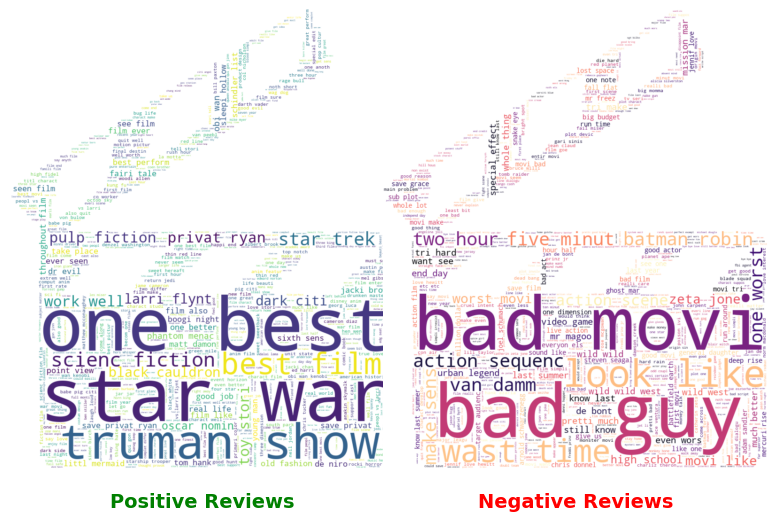

In [40]:
## Positive reviews wordcloud
wordcloud_1 = visualize_class_wordcloud(odds_ratio_enhanced,1,600,language='english',mask=mask,show=False)

## Negative reviews wordcloud
wordcloud_0 = visualize_class_wordcloud(odds_ratio_enhanced,0,600,language='english',mask=mask,show=False)


# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_1, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("Positive Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'green'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_0, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("Negative Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'red'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


**Remarque :**

Les wordclouds obtenu à la suite ne sont pas si différents des wordclouds obtenu par la présence seule des bi-grammes. On peut constater que la prise en considération des tri-grammes n'apporte pas grand-chose ici, et le temps de calcul est très pénible.

À l'aide des wordclouds obtenus au début en utilisant que des mots unitaires, on peut commencer à classifier les sentiments, et avec les wordclouds obtenus avec les bi-grammes, on peut commencer à associer des concepts (films ou acteurs) aux sentiments positifs et négatifs.

## B.6. TF-IDF EMBEDDING :

Le TF-IDF (Term Frequency - Inverse Document Frequency) est une technique de traitement du langage naturel qui permet de transformer du texte en un vecteur de nombres. Le processus consiste à calculer un score TF-IDF pour chaque mot dans chaque document d'un corpus, où le score TF-IDF est défini comme le produit de la fréquence du terme (TF) et de l'inverse de la fréquence dans le corpus (IDF). La formule pour le score TF-IDF est donnée par :

$$\text{tf-idf}(t,d)=\text{tf}(t,d)×\text{idf}(t)$$

où $t$ est un terme (mot), $d$ est un document, $\text{tf}(t,d)$ est la fréquence du terme $t$ dans le document $d$ et $\text{idf}(t)$ est l'inverse de la fréquence du terme $t$ dans le corpus.

L'embedding TF-IDF consiste à utiliser la technique TF-IDF pour générer des embeddings de mots (représentations vectorielles de mots) à partir d'un corpus de documents. Ces embeddings peuvent ensuite être utilisés comme entrée pour un modèle de classification de texte.

Pour utiliser l'embedding TF-IDF avec la base de données IMDB (Internet Movie Database) qui contient des critiques de films, nous devons d'abord prétraiter les données en les nettoyant. Ensuite, nous pouvons utiliser la classe TfidfVectorizer du module scikit-learn pour générer les embeddings, et on va comparer les résultats obtenus avec un Count-Vectorizer.

**Il est important de noter que les termes qui apparaissent souvent dans un document donné, mais pas dans d'autres documents de l'ensemble de données, peuvent donc avoir un poids plus important pour la classification de sentiments.**



In [41]:
## pre-processing data by activating : removing punctuation, removing numbers, lower-casing, removing stopwords, normalizing, stemming
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the datasets for both tfidf embedding and count embeddings (for comparison)
tfidf = TfidfVectorizer(max_features=10000)
cv = CountVectorizer(max_features=10000)

odds_ratio_tfidf = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=tfidf)
odds_ratio_count = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=cv)


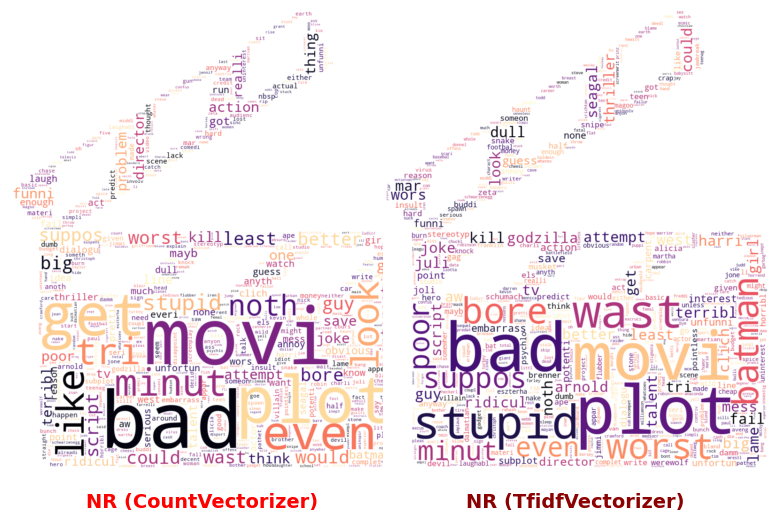

In [42]:
## Negative reviews wordcloud with count vectorizer
wordcloud_0_count = visualize_class_wordcloud(odds_ratio_count,0,600,language='english',mask=mask,show=False)

## Negative reviews wordcloud with tf-idf vectorizer
wordcloud_0_tfidf = visualize_class_wordcloud(odds_ratio_tfidf,0,600,language='english',mask=mask,show=False)

# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_0_count, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("NR (CountVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'red'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_0_tfidf, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("NR (TfidfVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'#8B0000'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


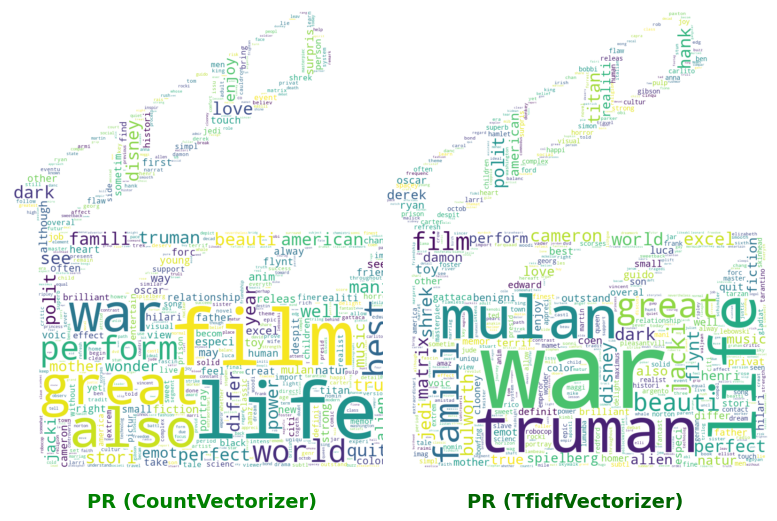

In [43]:
## Positive reviews wordcloud with count vectorizer
wordcloud_1_count = visualize_class_wordcloud(odds_ratio_count,1,600,language='english',mask=mask,show=False)

## Positive reviews wordcloud with tf-idf vectorizer
wordcloud_1_tfidf = visualize_class_wordcloud(odds_ratio_tfidf,1,600,language='english',mask=mask,show=False)

# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_1_count, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("PR (CountVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'green'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_1_tfidf, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("PR (TfidfVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'#006400'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


**Commentaires :**

* **Negative reviews :** TF-IDF donne des résultats qui mettent en évidence plus de mots négatifs que le Count-Vectorizer, tel que "stupid", ou "waste". 
* **Positive reviews :** Les résultats entre les deux sont plus ou moins les mêmes.

**Mais pourquoi?**

Le TF-IDF est meilleur que le Count-Vectorizer lorsqu'il s'agit d'un problème de classification de sentiments grace à la **Pondération des termes :** Le TF-IDF attribue des poids différents aux termes en fonction de leur fréquence dans le document et leur fréquence inverse dans l'ensemble du corpus. Le Count Vectorizer tient compte que de la fréquence d'apparition des mots, alors que TF-IDF attribut une certaine "importance" au mots via la formule précisée en haut. Ainsi, les termes qui apparaissent fréquemment dans un document mais rarement dans l'ensemble du corpus seront pondérés plus lourdement. Cela aide à atténuer l'impact des mots courants qui ne sont pas spécifiques à un document particulier.




### Que-ce-passe t'il si on ne retire pas les stop-words pour TF-IDF?

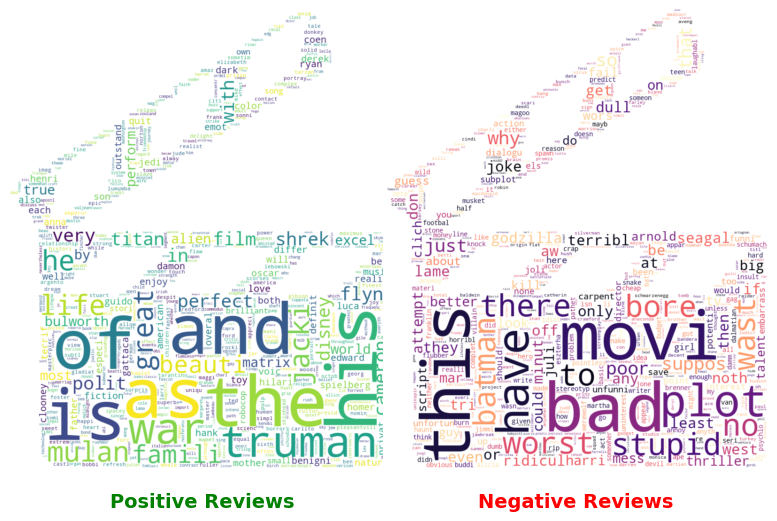

In [45]:
## Reprocessing text, but without removing stop words this time
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=False, norm=True, stemming=True)

## Calculating the odds ratio of the datasets for tfidf embedding 
tfidf = TfidfVectorizer(max_features=10000)
odds_ratio_tfidf = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=tfidf)

## Positive reviews wordcloud
wordcloud_1 = visualize_class_wordcloud(odds_ratio_tfidf,1,600,language='english',mask=mask,show=False)

## Negative reviews wordcloud
wordcloud_0 = visualize_class_wordcloud(odds_ratio_tfidf,0,600,language='english',mask=mask,show=False)

# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_1, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("Positive Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'green'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_0, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("Negative Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'red'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


**Remarque :** 
Bizarrement, le wordcloud des reviews négatifs reste toujours capable de mettre en évidence quelques mots qui décrivent des mauvais sentiments, alors que le wordcloud des reviews positifs est complètement bombardé avec les stopwords classiques de la langue anglaise.

**Explication :**

Dans certains cas, TF-IDF peut être plus efficace pour la classification des sentiments négatifs que pour les sentiments positifs. Cela peut s'expliquer par le fait que les mots négatifs sont souvent **plus rares et plus spécifiques.** En autre mots : 

Les mots associés à des sentiments négatifs tels que "hate", "horrible" et "terrible" sont souvent moins fréquents que les mots associés à des sentiments positifs tels que "good", "nice" et "like". Cela signifie que les mots négatifs peuvent avoir un poids plus important dans la méthode TF-IDF, car ils sont plus spécifiques à un sentiment négatif donné. Les mots positifs, par contre, auront un poids moins important car ils sont moins exclusifs au sentiment positif (On trouve des mots positifs dans des documents négatifs, par exemple "i don't **like** it", "not **good**", si on utilise des bi-gramme, on peut s'y retrouver).

**On a plus la tendance de dire : "not good" pour exprimer un sentiment négatif, pour être moins méchant, que de dire "not bad" pour exprimer un sentiment positif, au lieu d'utiliser un terme plus gentil tel que "good", ou "great". En gros, on a la tendance d'exprimer nos sentiments en essayant d'être le plus gentil possible, ha!**

Dans certains domaines, il peut être plus important de détecter les sentiments négatifs que les sentiments positifs. Par exemple, dans le domaine de la surveillance de la réputation en ligne, il est plus intéressant de détecter les critiques négatives que les commentaires positifs. Dans ces cas, une erreur de classification pour un sentiment positif peut être moins préjudiciable qu'une erreur de classification pour un sentiment négatif.


## B.7. Réduction de la taille du vocabulaire :

La réduction du vocabulaire peut améliorer les résultats, plus spécifiquement : 


* Ça peut aider à éviter le surapprentissage (overfitting) du modèle. Le surapprentissage se produit lorsque le modèle apprend à mémoriser les données d'entraînement plutôt que de généraliser à de nouvelles données. Si le vocabulaire est trop grand, il est possible que le modèle apprenne à mémoriser les mots spécifiques à l'ensemble d'entraînement, plutôt que d'apprendre à reconnaître les motifs généraux qui permettent de classifier les sentiments. En réduisant le vocabulaire, on peut réduire le risque de surapprentissage et améliorer la capacité du modèle à généraliser à de nouvelles données.


* Ça peut permettre d'améliorer la vitesse de traitement des données, ce qui peut être particulièrement important dans le cas de grandes bases de données. En effet, plus le vocabulaire est grand, plus le temps de calcul nécessaire pour traiter les données sera important. En réduisant le vocabulaire, on peut accélérer le traitement des données et rendre le modèle plus efficace.

In [46]:
# max_df: float (ratio) / integer(number) of document above which we remove the word)
# min_df: float (ratio) / integer(number) of document under which we remove the word)

min_df = 1             
max_df = 0.3
max_features = 10000

## Initializing vectorizers
cv = CountVectorizer(min_df=min_df,max_df=max_df,max_features=max_features)
tfidf = TfidfVectorizer(min_df=min_df,max_df=max_df,max_features=max_features)

## pre-processing data by activating : no need to remove stopwords, max_df will take care of it
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the datasets for both tfidf embedding and count embeddings (for comparison)
odds_ratio_tfidf = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=tfidf)
odds_ratio_count = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=cv)

# C) Modèles de Machine Learning

## C.1. Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes pour évaluer les performance des modèles : 
- Accuracy
- Courbe ROC-AUC
- F1-score

###  La métrique d'accuracy :

La mesure d'accuracy est une métrique couramment utilisée pour évaluer la performance d'un modèle de classification. Elle représente le taux de prédictions correctes effectuées par le modèle, c'est-à-dire le nombre de prédictions correctes divisé par le nombre total de prédictions.

Formellement, si $y_i$ est la valeur réelle de l'observation $i$ et $\hat{y_i}$ est la valeur prédite par le modèle, l'accuracy est définie comme suit :

$$accuracy = \frac{1}{n}\sum_{i=1}^{n} \mathbb{1}_{y_i = \hat{y_i}}$$



où $n$ est le nombre total d'observations et $\mathbb{1}_{y_i = \hat{y_i}}$ est une fonction indicatrice qui vaut 1 si la prédiction est correcte et 0 sinon.

**L'avantage de l'accuracy** est qu'elle est facile à comprendre et à interpréter. Elle donne une mesure simple et intuitive de la performance globale du modèle. Elle peut également être utilisée pour comparer des modèles différents sur le même jeu de données.

**L'inconvénient de l'accuracy** est le fait qu'elle peut être trompeuse dans certaines situations, en particulier lorsque les classes sont déséquilibrées. Par exemple, si 95% des observations appartiennent à la classe A et que le modèle prédit toujours la classe A, l'accuracy sera de 95%, mais le modèle n'aura en réalité rien appris d'utile. Dans ce cas, il est préférable d'utiliser d'autres métriques comme la précision, le recall ou la F1-score qui prennent en compte la répartition des classes dans les données.

###  La Courbe ROC-AUC :


###  Le F1-score :


## C.2. Evolution du temps de calcul en fonction de la taille du dataset

In [65]:
## big dataset preprocessing
tfidf = TfidfVectorizer(max_features=10000)
X_train_processed = text_processor(X_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)
X_test_processed = text_processor(X_test, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)
X_embedded = tfidf.fit_transform(X_train_processed)
X_test_embedded = TfidfVectorizer(decode_error="replace",vocabulary=tfidf.vocabulary_).fit_transform(X_test_processed)
print(len(X_train_processed))
print(len(X_test_processed))

25000
25000


In [66]:
def batch_set(X_train,Y_train,data_size) :
    
    # select an equal number of positive and negative samples
    num_pos = int(data_size / 2)
    num_neg = int(data_size / 2)
    pos_indices = np.random.choice(np.where(Y_train == 1)[0], size = num_pos, replace=False)
    neg_indices = np.random.choice(np.where(Y_train == 0)[0], size = num_neg, replace=False)

    # select the remaining samples randomly
    remaining_indices = np.setdiff1d(np.arange(X_train.shape[0]), np.concatenate([pos_indices, neg_indices]))
    remaining_indices = np.random.choice(remaining_indices, size = data_size - num_pos - num_neg, replace=False)

    # combine the selected indices and shuffle them
    selected_indices = np.concatenate([pos_indices, neg_indices, remaining_indices])
    np.random.shuffle(selected_indices)

    # extract the corresponding samples from X_train and Y_train
    X_batch = X_train[selected_indices]
    Y_batch = Y_train[selected_indices]

    return X_batch, Y_batch

In [67]:
train_sizes = [1000, 2500, 5000, 10000, 15000, 20000, 25000]

training_times_lr  =  []
training_times_svm =  []
training_times_nb  =  []

for size in train_sizes:
    lr_clf = LogisticRegression(max_iter=1000)
    nb_clf = MultinomialNB()
    svm_clf = LinearSVC(max_iter=1000)
    X_batch,y_batch = batch_set(X_embedded,Y_train,size)
    ## Logistic Regression
    start = time.time()
    lr_clf.fit(X_batch,y_batch)
    training_times_lr.append((time.time()-start)*10e3)
    ## Naive Bayes
    start = time.time()
    nb_clf.fit(X_batch,y_batch)
    training_times_nb.append((time.time()-start)*10e3)
    ## SVM
    start = time.time()
    svm_clf.fit(X_batch,y_batch)
    training_times_svm.append((time.time()-start)*10e3)

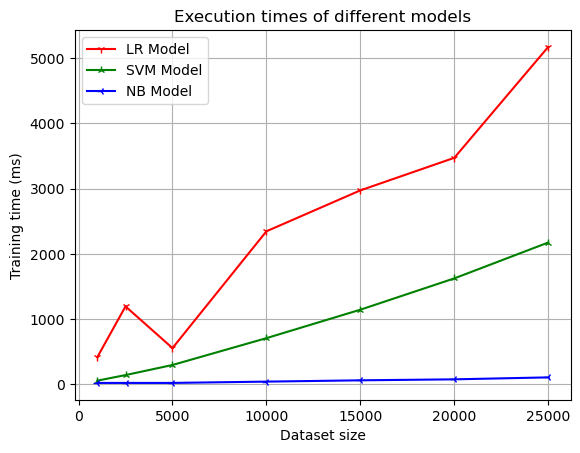

In [69]:
import matplotlib.pyplot as plt

plt1, = plt.plot(train_sizes, training_times_lr, label = "LR Model", color="red", marker="1") 
plt2, = plt.plot(train_sizes, training_times_svm, label = "SVM Model", color="green", marker="2")
plt3, = plt.plot(train_sizes, training_times_nb, label = "NB Model", color="blue", marker="3") 

plt.title("Execution times of different models")
plt.legend(handles=[plt1, plt2, plt3], loc = "upper left")
plt.grid(True)
plt.xlabel("Dataset size")
plt.ylabel("Training time (ms)")
plt.show()

**Commentaires :**

La vitesse à laquelle un modèle d'apprentissage automatique fonctionne dépend de nombreuses variables, notamment de la taille de l'ensemble de données, du nombre de caractéristiques et de la complexité du modèle. Cependant, en général, **Naive Bayes** est perçu comme l'un des algorithmes de classification les plus rapides, suivi par la **régression logistique** et le **SVM linéaire**.

Naive Bayes est notamment rapide car il s'agit d'un modèle probabiliste simple qui ne nécessite pas d'optimisation itérative comme la régression logistique ou le SVM. Il évalue directement les probabilités a posteriori des classes en fonction des caractéristiques en utilisant le théorème de Bayes et peut ainsi créer rapidement des prédictions.

La régression logistique et le SVM linéaire sont des modèles plus polyvalents qui utilisent des algorithmes d'optimisation pour déterminer les poids optimaux des caractéristiques. En général, le SVM peut être plus lent que la régression logistique car il implique la résolution d'un problème de programmation quadratique pour localiser l'hyperplan de séparation. Cependant, la régression logistique et le SVM linéaire sont généralement plus rapides que les modèles plus complexes comme les arbres de décision, les forêts aléatoires ou les réseaux neuronaux.

Il est important de noter que la vitesse comparative de ces modèles peut varier en fonction de l'implémentation spécifique, de la taille et de la complexité de l'ensemble de données, et du problème spécifique que vous tentez de résoudre. Par conséquent, il est suggéré de réaliser des expériences et de comparer les performances de différents modèles pour un problème particulier, plutôt que de se fier uniquement à leur vitesse relative.


## C.3. Evolution du temps de calcul en fonction de la taille du vocabulaire

In [83]:
vocab_size = [5000, 10000, 15000, 20000, 25000, 30000,40000,50000,100000]

data_size = 5000
X,y = batch_set(X_train,Y_train,data_size)
X = text_processor(X, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)


embedding_times    = []
training_times_lr  = []
training_times_nb  = []
training_times_svm = []

for v in vocab_size :
    ## Embedding
    start = time.time()
    tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=v)
    X_embedded = tfidf.fit_transform(X)
    embedding_times.append((time.time()-start)*10e3)
    
    lr_clf = LogisticRegression(max_iter=1000)
    nb_clf = MultinomialNB()
    svm_clf = LinearSVC(max_iter=1000)
    
    ## LR_CLF
    start = time.time()
    lr_clf.fit(X_embedded,y)
    training_times_lr.append((time.time()-start)*10e3)
    
    ## NB_CLF
    start = time.time()
    nb_clf.fit(X_embedded,y)
    training_times_nb.append((time.time()-start)*10e3)
    
    ## SVM_CLF
    start = time.time()
    svm_clf.fit(X_embedded,y)
    training_times_svm.append((time.time()-start)*10e3)

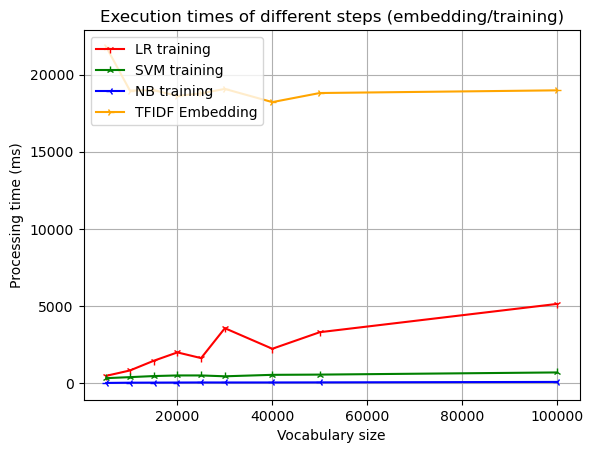

In [93]:
import matplotlib.pyplot as plt

plt1, = plt.plot(vocab_size, training_times_lr, label = "LR training", color="red", marker="1") 
plt2, = plt.plot(vocab_size, training_times_svm, label = "SVM training", color="green", marker="2")
plt3, = plt.plot(vocab_size, training_times_nb, label = "NB training", color="blue", marker="3")
plt4, = plt.plot(vocab_size, embedding_times, label = "TFIDF Embedding", color="orange", marker="4")

plt.title("Execution times of different steps (embedding/training)")
plt.legend(handles=[plt1, plt2, plt3, plt4], loc = "upper left")
plt.grid(True)
plt.xlabel("Vocabulary size")
plt.ylabel("Processing time (ms)")
plt.show()

## C.4. Variations de la validation croisée

In [152]:
data_size = 12500
X,y = batch_set(X_train,Y_train,data_size)
X = text_processor(X, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)
Xt,yt = batch_set(X_test,Y_test,data_size)
Xt = text_processor(Xt, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

# Embedding
tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=10000)
X_embedded = tfidf.fit_transform(X)
Xt_embedded = TfidfVectorizer(decode_error="replace",vocabulary=tfidf.vocabulary_).fit_transform(Xt)

In [180]:
############################################## SANS VALIDATION CROISEE  ################################################
import random
window=30
deb = random.randint(1,Xt_embedded.shape[0]-window)
fin = deb+window
print("Beginning at : ", deb)
print("Ending at : ", fin)
print("Window size : ", window,'\n')

# Création modèle
lr_clf = LogisticRegression(max_iter=1000)
nb_clf = MultinomialNB()
svm_clf = LinearSVC(max_iter=1000)

# Apprentissage
lr_clf.fit(X_embedded,y)
nb_clf.fit(X_embedded,y)
svm_clf.fit(X_embedded,y)

# Prédictions sur quelques données
yhat_lr = lr_clf.predict(X_embedded[deb:fin])
yhat_nb = nb_clf.predict(X_embedded[deb:fin])
yhat_svm = svm_clf.predict(X_embedded[deb:fin])
real_y = y[deb:fin]

for i in range(len(yhat_lr)):
    if real_y[i] != yhat_lr[i]: print(colored(str(yhat_lr[i]), 'red'), end=' ')
    else: print(colored(str(yhat_lr[i]), 'green'), end=' ')
print(' -- LR PREDICTIONS -- Accuracy : ',accuracy_score(lr_clf.predict(X_embedded),y), '\n')

for i in range(len(yhat_nb)):
    if real_y[i] != yhat_nb[i]: print(colored(str(yhat_nb[i]), 'red'), end=' ')
    else: print(colored(str(yhat_nb[i]), 'green'), end=' ')
print(' -- NB PREDICTIONS -- Accuracy : ',accuracy_score(nb_clf.predict(X_embedded),y), '\n')
for i in range(len(yhat_svm)):
    if real_y[i] != yhat_svm[i]: print(colored(str(yhat_svm[i]), 'red'), end=' ')
    else: print(colored(str(yhat_svm[i]), 'green'), end=' ')
print(' -- SVM PREDICTIONS -- Accuracy : ',accuracy_score(svm_clf.predict(X_embedded),y), '\n')
for i in range(len(real_y)):
    print(colored(str(real_y[i]), 'blue'), end=' ')
print(' -- REAL Y VALUES')

Beginning at :  6354
Ending at :  6384
Window size :  30 

0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0  -- LR PREDICTIONS -- Accuracy :  0.93168 

0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0  -- NB PREDICTIONS -- Accuracy :  0.89552 

0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0  -- SVM PREDICTIONS -- Accuracy :  0.98536 

0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1  -- REAL Y VALUES


In [119]:
##################################### EN VALIDATION CROISEE, KFOLD, SHUFFLE = FALSE #######################################

# Création modèle
lr_clf = LogisticRegression(max_iter=1000)
nb_clf = MultinomialNB()
svm_clf = LinearSVC(max_iter=1000)

# Prédictions sur quelques données
kfold = KFold(n_splits=5, shuffle=False)
scores_cv_lr = cross_val_score(lr_clf, X_embedded, y,   cv=kfold)
scores_cv_nb = cross_val_score(nb_clf, X_embedded, y,   cv=kfold)
scores_cv_svm = cross_val_score(svm_clf, X_embedded, y, cv=kfold)


print('Score sur les données d\'entraînement (LR_CLF)  :', scores_cv_lr )
print('Score sur les données d\'entraînement (NB_CLF)  :', scores_cv_nb )
print('Score sur les données d\'entraînement (SVM_CLF) :', scores_cv_svm )

Score sur les données d'entraînement (LR_CLF)  : [0.8844 0.8708 0.8752 0.8852 0.8784]
Score sur les données d'entraînement (NB_CLF)  : [0.8608 0.8492 0.86   0.8688 0.8588]
Score sur les données d'entraînement (SVM_CLF) : [0.8736 0.8728 0.8744 0.878  0.8772]


In [120]:
##################################### EN VALIDATION CROISEE, KFOLD, SHUFFLE = TRUE #######################################

# Création modèle
lr_clf = LogisticRegression(max_iter=1000)
nb_clf = MultinomialNB()
svm_clf = LinearSVC(max_iter=1000)

# Prédictions sur quelques données
kfold = KFold(n_splits=5, shuffle=True)
scores_cv_lr = cross_val_score(lr_clf, X_embedded, y,   cv=kfold)
scores_cv_nb = cross_val_score(nb_clf, X_embedded, y,   cv=kfold)
scores_cv_svm = cross_val_score(svm_clf, X_embedded, y, cv=kfold)


print('Score sur les données d\'entraînement (LR_CLF)  :', scores_cv_lr )
print('Score sur les données d\'entraînement (NB_CLF)  :', scores_cv_nb )
print('Score sur les données d\'entraînement (SVM_CLF) :', scores_cv_svm )

Score sur les données d'entraînement (LR_CLF)  : [0.8784 0.892  0.866  0.8876 0.884 ]
Score sur les données d'entraînement (NB_CLF)  : [0.8652 0.8568 0.866  0.8604 0.8592]
Score sur les données d'entraînement (SVM_CLF) : [0.8764 0.8784 0.866  0.882  0.8856]


In [121]:
################################ EN VALIDATION CROISEE, STRATIFIEDKFOLD, SHUFFLE = FALSE ##################################

# Création modèle
lr_clf = LogisticRegression(max_iter=1000)
nb_clf = MultinomialNB()
svm_clf = LinearSVC(max_iter=1000)

# Prédictions sur quelques données
strat_kfold = StratifiedKFold(n_splits=5, shuffle=False)
scores_cv_lr = cross_val_score(lr_clf, X_embedded, y,   cv=strat_kfold)
scores_cv_nb = cross_val_score(nb_clf, X_embedded, y,   cv=strat_kfold)
scores_cv_svm = cross_val_score(svm_clf, X_embedded, y, cv=strat_kfold)

print('Score sur les données d\'entraînement (LR_CLF)  :', scores_cv_lr )
print('Score sur les données d\'entraînement (NB_CLF)  :', scores_cv_nb )
print('Score sur les données d\'entraînement (SVM_CLF) :', scores_cv_svm )

Score sur les données d'entraînement (LR_CLF)  : [0.8836 0.8704 0.8756 0.8848 0.8776]
Score sur les données d'entraînement (NB_CLF)  : [0.8608 0.8492 0.8604 0.868  0.86  ]
Score sur les données d'entraînement (SVM_CLF) : [0.8724 0.8736 0.8748 0.8784 0.8764]


In [122]:
################################ EN VALIDATION CROISEE, STRATIFIEDKFOLD, SHUFFLE = TRUE ##################################

# Création modèle
lr_clf = LogisticRegression(max_iter=1000)
nb_clf = MultinomialNB()
svm_clf = LinearSVC(max_iter=1000)

# Prédictions sur quelques données
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
scores_cv_lr = cross_val_score(lr_clf, X_embedded, y,   cv=strat_kfold)
scores_cv_nb = cross_val_score(nb_clf, X_embedded, y,   cv=strat_kfold)
scores_cv_svm = cross_val_score(svm_clf, X_embedded, y, cv=strat_kfold)

print('Score sur les données d\'entraînement (LR_CLF)  :', scores_cv_lr )
print('Score sur les données d\'entraînement (NB_CLF)  :', scores_cv_nb )
print('Score sur les données d\'entraînement (SVM_CLF) :', scores_cv_svm )

Score sur les données d'entraînement (LR_CLF)  : [0.8812 0.8892 0.8732 0.8708 0.882 ]
Score sur les données d'entraînement (NB_CLF)  : [0.862  0.8524 0.8684 0.8588 0.856 ]
Score sur les données d'entraînement (SVM_CLF) : [0.8676 0.8696 0.878  0.8744 0.8868]


### Comparaison initiale du score de test (Accuracy)

In [181]:
import random
window=30
deb = random.randint(1,Xt_embedded.shape[0]-window)
fin = deb+window
print("Beginning at : ", deb)
print("Ending at : ", fin)
print("Window size : ", window,'\n')
# Création modèle, phase d'apprentissage
lr_clf = LogisticRegression(max_iter=1000)
nb_clf = MultinomialNB()
svm_clf = LinearSVC(max_iter=1000)

# Apprentissage
lr_clf.fit(X_embedded,y)
nb_clf.fit(X_embedded,y)
svm_clf.fit(X_embedded,y)

# Prédictions sur quelques données
yhat_lr = lr_clf.predict(Xt_embedded[deb:fin])
yhat_nb = nb_clf.predict(Xt_embedded[deb:fin])
yhat_svm = svm_clf.predict(Xt_embedded[deb:fin])
real_y = yt[deb:fin]

for i in range(len(yhat_lr)):
    if real_y[i] != yhat_lr[i]: print(colored(str(yhat_lr[i]), 'red'), end=' ')
    else: print(colored(str(yhat_lr[i]), 'green'), end=' ')
print(' -- LR PREDICTIONS -- Accuracy : ',accuracy_score(lr_clf.predict(Xt_embedded),yt), '\n')

for i in range(len(yhat_nb)):
    if real_y[i] != yhat_nb[i]: print(colored(str(yhat_nb[i]), 'red'), end=' ')
    else: print(colored(str(yhat_nb[i]), 'green'), end=' ')
print(' -- NB PREDICTIONS -- Accuracy : ',accuracy_score(nb_clf.predict(Xt_embedded),yt), '\n')
for i in range(len(yhat_svm)):
    if real_y[i] != yhat_svm[i]: print(colored(str(yhat_svm[i]), 'red'), end=' ')
    else: print(colored(str(yhat_svm[i]), 'green'), end=' ')
print(' -- SVM PREDICTIONS -- Accuracy : ',accuracy_score(svm_clf.predict(Xt_embedded),yt), '\n')
for i in range(len(real_y)):
    print(colored(str(real_y[i]), 'blue'), end=' ')
print(' -- REAL Y VALUES')



Beginning at :  11101
Ending at :  11131
Window size :  30 

1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0  -- LR PREDICTIONS -- Accuracy :  0.86904 

1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0  -- NB PREDICTIONS -- Accuracy :  0.83224 

1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0  -- SVM PREDICTIONS -- Accuracy :  0.85288 

1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0  -- REAL Y VALUES


### La validation croisée est elle stable?

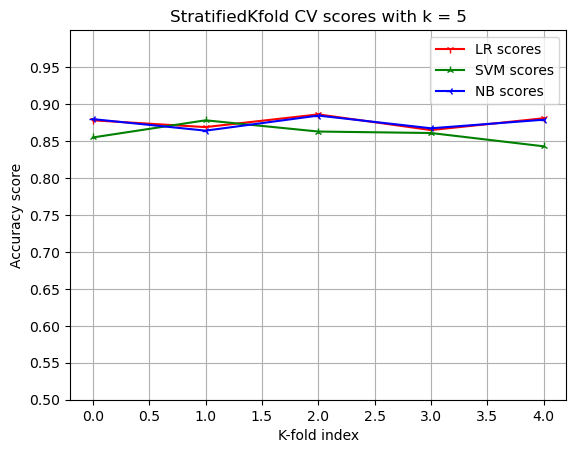

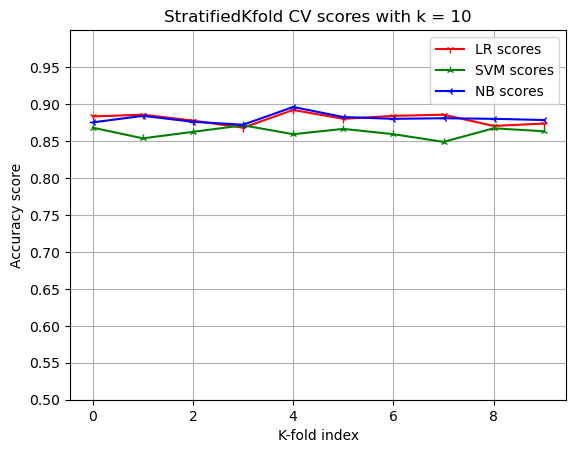

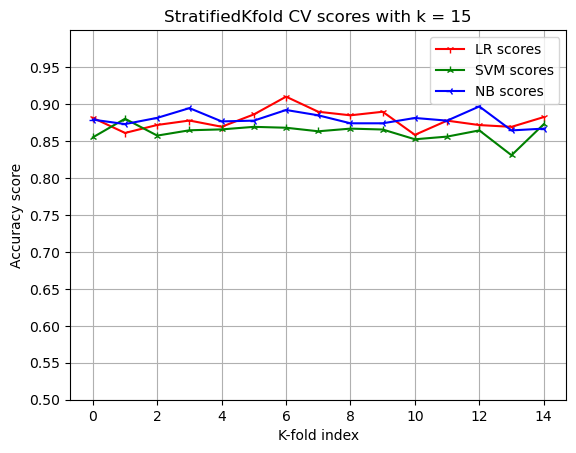

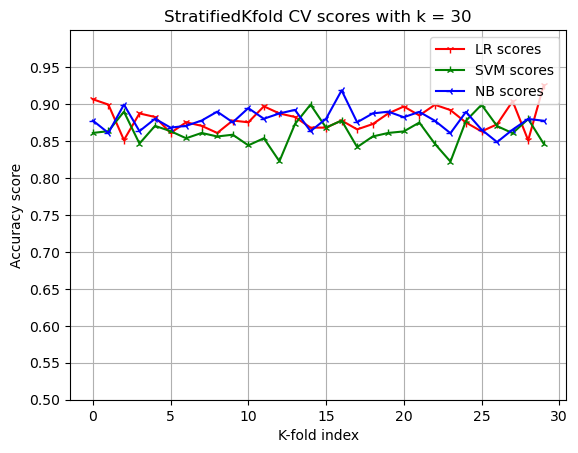

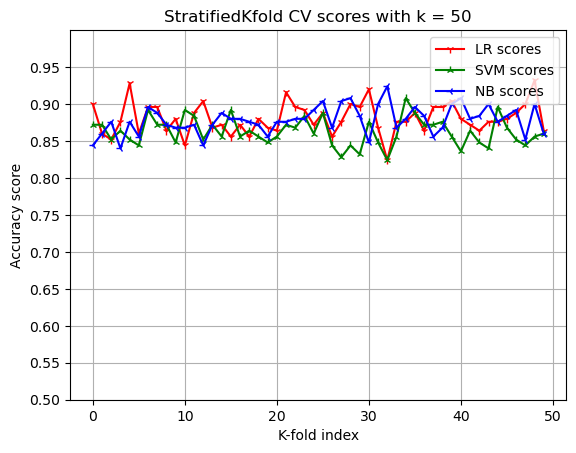

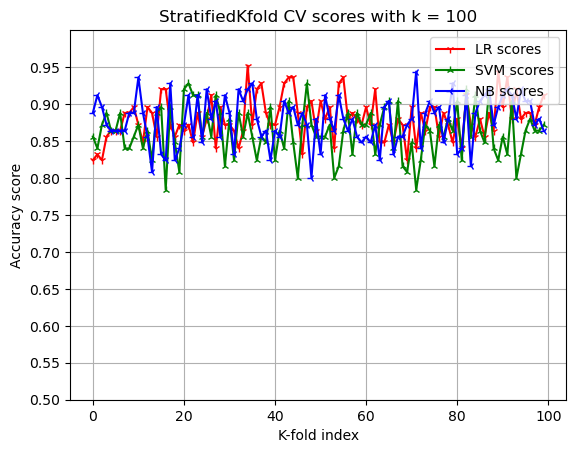

In [192]:
splits = [5,10,15,30,50,100]

for n in splits :
    # Prédictions sur quelques données
    strat_kfold = StratifiedKFold(n_splits=n, shuffle=True)
    scores_cv_lr = cross_val_score(lr_clf, X_embedded, y,   cv=strat_kfold)
    scores_cv_nb = cross_val_score(nb_clf, X_embedded, y,   cv=strat_kfold)
    scores_cv_svm = cross_val_score(svm_clf, X_embedded, y, cv=strat_kfold)

    plt1, = plt.plot([i for i in range(n)], scores_cv_lr, label = "LR scores", color="red", marker="1") 
    plt2, = plt.plot([i for i in range(n)], scores_cv_nb, label = "SVM scores", color="green", marker="2")
    plt3, = plt.plot([i for i in range(n)], scores_cv_svm, label = "NB scores", color="blue", marker="3")

    titre = "StratifiedKfold CV scores with k = " + str(n)
    plt.title(titre)
    plt.yticks(np.arange(y.min(), y.max(), 0.05))
    plt.ylim(0.5, 1)
    plt.legend(handles=[plt1, plt2, plt3], loc = "upper right")
    plt.grid(True)
    plt.xlabel("K-fold index")
    plt.ylabel("Accuracy score")
    plt.show()

#### Remarques :

Au fur et à mesure que le nombre de plis augmente, la variance de l'estimation de la validation croisée diminue généralement et l'estimation devient plus stable. Toutefois, l'augmentation du nombre de plis réduit également le nombre d'échantillons dans chaque pli, ce qui peut entraîner une variance plus élevée dans l'estimation de la performance du modèle. 

On peut remarquer à partir des figures précédentes qu'a partir de `K = 15`, la variance dans le score de validation croisée devient plus intense, cela revient à la taille fortement réduite des plis. 

Par conséquent, la stabilité de l'estimation par validation croisée dépend de l'équilibre entre ces deux effets. Une bonne valeur de k-folds donne autant de plis que possibles, qui ne sont pas très différents en ce qui concerne le score. Génralement on choisie `K = 5` ou `K = 10`.

## C.5. Gridsearching

Dans cette partie, nous allons faire un grid search sur les différents paramètres de pré-traitement de texte, d'embedding ainsi que des modèles utilisés pour l'apprentissage. Pour des raisons de complexité, nous allons décomposer le grid search en batchs de combinaisons de paramètres, et génerer les résultats au fur et à mesure dans des fichiers externes.

Par exemple, soit **n** la n-ieme combinaison de paramètres, nous allons alors trouver les résultats **Accuracy, F1 score, Roc-Auc**  dans un fichier nommé "output_X_to_Y.txt", avec **n** étant une valeur entre **X** et **Y**. Cela nous permet de facilement identifier les paramètres utilisé pour l'obtention des résultats qui maximisent les différents scores, et ça nous donne la possibilité d'interrompre le gridsearching à n'importe quel moment puisqu'il y'a une écriture dans un fichier en temps réel (les resultats sont sauvgardés).

In [12]:
from sklearn.model_selection import ParameterGrid

# Définition de la fonction GridSearch

class GridSearch:
    """ Classe pour l'optimisation de paramètres par GridSearch.
    """
    def __init__(self, datax, datay, params):
        """ Constructeur de la classe GridSearch.
            @param datax: list(str), corpus de textes
            @param datay: list(int), classes correspondantes
            @param model: classifieur par encore entraîné
            @params: dict(str:object), dictionnaire des paramètres à tester et des valeurs qu'elles peuvent prendre
        """
        # Initialisation des scores ainsi que des paramètres correspondant
        self.scores = []
        self.params = []
        
        processing_params = list( ParameterGrid(params['processing']) )
        vectorizer_params = list( ParameterGrid(params['vectorizer']) )
        cv_params = list( ParameterGrid(params['cross_val']) )
        
        print('\n{} combinaisons de paramètres à tester...' . format( len(processing_params) * len(vectorizer_params) * len(cv_params) * 3 ))
        
        # Liste des différents modèles à tester
        classes = [ LinearSVC, MultinomialNB, LogisticRegression ]
        
        # Compteur itérations pour affichage dans le log
        i = 0
        
        for proc_grid in processing_params:
            # Pré-traitement du corpus selon les paramètres choisis
            processed_datax = text_processor(datax, **proc_grid)
            
            for func in classes:
                if func != MultinomialNB:
                    for C in params['cross_val']['C']:
                        # Pour chaque paramètre de régularisation
                        model = func( C = C )
                        #model.set_params(max_iter=5000)    

                        for vec_grid in vectorizer_params:
                            
                            # Représentation sous forme vectorielle
                            vectorizer = vec_grid['type'](ngram_range=vec_grid['ngram_range'])
                            X = vectorizer.fit_transform(processed_datax)

                            # Cross-validation
                            strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
                            scores_cv = np.mean( cross_val_score(model, X, datay, cv=strat_kfold, scoring=['f1', 'accuracy']) )
                            print('Iter {} : model: {}, vectorizer: {}, params: {}, C: {} --> {}' .format(str(i), str(model), str(vec_grid), str(proc_grid), str(C), str(scores_cv)) )
                            
                            self.scores.append(scores_cv)
                            self.params.append((model, vec_grid, proc_grid, C))
                            i += 1
                else:
                    model = func()
                    #model.set_params(max_iter=5000)    

                    for vec_grid in vectorizer_params:
                            
                        # Représentation sous forme vectorielle
                        vectorizer = vec_grid['type'](ngram_range=vec_grid['ngram_range'])
                        X = vectorizer.fit_transform(processed_datax)
                        model.fit(X, datay)

                        # Cross-validation
                        strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
                        scores_cv = np.mean( cross_val_score(model, X, datay, cv=strat_kfold, scoring='f1') )
                        print('Iter {} : model: {}, vectorizer: {}, params: {} -> {}' .format(str(i), str(model), str(vec_grid), str(proc_grid), str(scores_cv)) )
                        
                        self.scores.append(scores_cv)
                        self.params.append((str(model), str(vec_grid), str(proc_grid)))
                        i += 1

In [13]:
import pandas as pd
from sklearn.model_selection import ParameterGrid

class BatchGridSearch:
    """ Classe pour l'optimisation de paramètres par GridSearch.
    """
    def __init__(self, datax, datay, params, params_filename='params.txt'):
        """ Constructeur de la classe GridSearch.
            Permet d'écrire dans un fichier param_filename toutes les combinaisons de paramètres à tester.
            @param datax: list(str), corpus de textes
            @param datay: list(int), classes correspondantes
            @params params: dict(str:object), dictionnaire des paramètres à tester et des valeurs qu'elles peuvent prendre
            @params_filename: str, fichier dans lequel on veut écrire la liste de nos paramètres
        """
        self.datax = datax
        self.datay = datay
        self.params = params
        self.params_filename = params_filename
        
        # Grilles de paramètres à tester
        processing_params = list( ParameterGrid(params['processing']) )
        vectorizer_params = list( ParameterGrid(params['vectorizer']) )
        model_params = list( ParameterGrid(params['model']) )
        cv_params = list( ParameterGrid(params['cross_val']) )
        
        # Paramètre du nombre de combinaisons au total
        self.n_combs_ = len(processing_params) * len(model_params) * len(vectorizer_params) * len(cv_params)

        # Ecriture dans un fichier
        with open(params_filename, 'w') as file:
            for processing in processing_params:
                for model in model_params:
                    for vectorizer in vectorizer_params:
                        for cv in cv_params:
                            params = {'processing' : processing, 'vectorizer': vectorizer, 'model': model, 'cross_val': cv}
                            file.write(str(params) + '\n')
        
    
    def compute_batch(self, from_, to_):
        """ Permet d'appliquer la cross-validation sur un batch de la grille de paramètres. La fonction crée un fichier de nom
            'out_{from_}_to_{to_}.txt' dans lequel chaque ligne contient l'indice de la ligne correspondante et le score du
            modèle testé en cross-validation. Les paramètres utilisés sont ceux allant de la ligne from_ à la ligne to_ dans le fichier nommé 
            self.params_filename.
            @params from_: int, indice de la ligne de départ du batch de paramètres à tester dans params_filename
            @param to_: int, indice de la ligne de fin de batch (comprise)
        """        
        # Récupération des paramètres du batch à tester
        with open(self.params_filename, 'r') as file:
            params_grid = file.readlines()
            for i in range(len(params_grid)):
                params_grid[i] = re.sub("<class 'sklearn.feature_extraction.text.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.svm.classes.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.svm._classes.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.naive_bayes.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.linear_model.logistic.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.linear_model._logistic.([A-Za-z]*)'>", r'\1', params_grid[i])
                
                params_grid[i] = eval( params_grid[i].strip('\n') )
                #params_grid[i]['vectorizer']['type'] = eval( params_grid[i]['vectorizer']['type'] )
    
        print('\n{} combinaisons de paramètres à tester...' . format( to_ - from_ + 1 ))
        
        # Nom du fichier de sortie
        out_filename = 'out_' + str(from_) + '_to_' + str(to_) + '.txt'
        
        # Initialisation du dictionnaire pour la conversion en DataFrame
        df = dict()
        
        with open(out_filename, 'w') as out_file:

            for i in tqdm(range(from_, to_+1)):
                params = params_grid[i]
                
                # Pré-traitement du corpus selon les paramètres choisis
                processed_datax = text_processor(self.datax, **params['processing'])
                
                # Initialisation du modèle
                func = params['model']['m']
                if func != MultinomialNB:
                    model = func( C = params['cross_val']['C'] )
                else:
                    model = func()
                    
                #model.set_params(max_iter=5000)
                # Représentation sous forme vectorielle
                vectorizer = params['vectorizer']['type'](ngram_range=params['vectorizer']['ngram_range'],max_features=params['vectorizer']['max_features'])
                X = vectorizer.fit_transform(processed_datax)

                # Cross-validation
                strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
                scores = cross_validate(model, X, self.datay, cv=strat_kfold, scoring = ['accuracy','f1','roc_auc'])
                accuracy = np.mean( scores['test_accuracy'] )
                f1 = np.mean( scores['test_f1'] )
                roc_auc = np.mean( scores['test_roc_auc'] )
                        
                # Ecriture du score dans le fichier de sortie
                out_file.write('{} {} {} {}\n'.format(i, accuracy, f1, roc_auc))
                
                # Ecriture dans un dictionnaire pour l'affichage DataFrame
                line = params
                line['model']['m'] = line['model']['m'].__name__
                line['vectorizer']['type'] = line['vectorizer']['type'].__name__
                
                df[i] = [ i for k, v in line.items() for i in v.values() ]
                df[i].append(accuracy)
        
        # Affichage de sortie
        print('\n*** Fin de traitement, voir le fichier {} ***'.format(out_filename))
        
        # Affichage DataFrame Pandas
        return pd.DataFrame.from_dict(df, orient='index', columns=['language', 'select line', 'lowercase', 'no number', 'no punctuation', 'no stopwords', 'normalize', 'stemming', 'ngram', 'vectorizer', 'model', 'regularization factor', 'score'])

In [14]:
# Lecture des scores (accuracy, f1) pour chaque combinaison de paramètres par BatchGridSearch

def load_scores_df(params_file, scores_files, scores_names):
    """ Lit les fichiers params_files des paramètres et la liste de fichiers dans scores_files, et renvoie les
        scores associés à chaque combinaison sous la forme d'un DataFrame pandas.
        @param params_file: str, nom du fichier contenant toutes les combinaisons de paramètres testées
        @param scores_files: list(str), liste des fichiers contenant les scores obtenus par combinaison
        @param scores_names: list(str), liste des noms des scores
    """
    with open(params_file,'r') as file:
    
        lines = file.readlines()
        data = [['ID','Language','Line','Lower','Remove digit','Remove punctuation','Remove stopwords','Normalize','Stemming','Max Features','N-gram range','Vectorizer','Model','C','Accuracy score','F1 score', 'ROC-AUC score']]
        
        # Mappings des vectorizers et modèles
        vmap = { CountVectorizer : 'Counter', TfidfVectorizer : 'Tf-Idf' }
        mmap = { LinearSVC : 'Linear SVC', LogisticRegression : 'Logistic Regression', MultinomialNB : 'Naive Bayes' }
        
        for i in range(len(lines)):
            line = lines[i].strip('\n')
            line = re.sub("<class 'sklearn.feature_extraction.text.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.svm.classes.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.svm._classes.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.naive_bayes.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.linear_model.logistic.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.linear_model._logistic.([A-Za-z]*)'>", r'\1', line)
            params = eval(line)

            processing = params['processing']
            vectorizer = params['vectorizer']
            model = params['model']
            cross_val = params['cross_val']
            data.append([i+1,processing['language'], processing['line'], processing['lowercase'], processing['no_num'], processing['no_punc'], processing['no_stopwords'], processing['norm'], processing['stemming'], vectorizer['max_features'], vectorizer['ngram_range'], vmap[vectorizer['type']], mmap[model['m']], cross_val['C']])
    
    for score_file in scores_files:
        with open(score_file,'r') as file:
            lines = file.readlines()
            
            for line in lines:
                i, accuracy, f1, roc_auc = line.split()
                data[int(i)+1] += [float(accuracy), float(f1), float(roc_auc)]
    
    return pd.DataFrame(data[1:], columns=data[0])

### Choix des paramètres à tester

A fin de réduire le temps de calcul le plus possible, tout en étant exhaustifs dans notre grid-searching, nous avons décidé de ne pas tester sur certains params:

   - `no_punc` : limité à True seulement, car la ponctuation n'apporte aucune information sur les sentiments.
   - `no_num` : limité à True seulement, car les chiffres n'apportent pas une information sur les sentiments non-plus.
   - `lowercase` : limité à True seulement, permet de réduire le nombre des combinaisons à tester et d'éviter le sur-apprentissage (il ne doit pas y avoir une différence entre Good et good et GOOD).
   - `no_stopwords` : limité à True seulement, car les stopwords vont causer du sur-apprentissage à coup sûr.
   - `vectorizer` : limité à Tfidf seulement, vu qu'il parait plus robuste que `CountVectorizer` dans les tests initiaux.
   - `ngram_range` : limité à (1,1) et (1,2) seulement, car on a pu constater précedemment que les bigrammes apportent du contexte supplémentaire, mais qu'ils ne sont pas suffisants pour décrire les sentiments (les unigrammes sont nécessaires aussi), alors que les tri-grammes ne décrivent pas grand chose.
   
Pour le reste des paramètres, nous n'avons pas suffisement d'information sur les résultats attendus donc nous avons choisi plusieurs valeurs possible.
Cette partie a pris le plus de temps dans ce projet, car nous utilisons directement le grand jeu de données pour des résultats fiables.
Nous allons après selectionner les meilleurs modèles et faire des tests et des gridsearch supplémentaires sur d'autres paramètres plus spécifiques.
  

In [15]:
params = {"processing": { "language": ['english'],
                          "line": [None],
                          "no_punc": [True],
                          "no_num": [True],
                          "lowercase": [True],
                          "norm": [False,True],
                          "no_stopwords": [True],
                          "stemming": [False,True] },
          "vectorizer": {"type": [ TfidfVectorizer ], "ngram_range": [(1,1),(1,2)], "max_features" : [5000, 10000, 15000, 30000, 50000]},
          "model": {"m": [ LinearSVC, MultinomialNB, LogisticRegression ] },
          "cross_val": { "C": [ 1 if i == 0 else i * 10 for i in range(5) ] }
         }

In [16]:
bgs = BatchGridSearch(X_train, Y_train, params, 'movie_param.txt')
print('{} combinaisaisons de paramètres à tester' . format(bgs.n_combs_))

600 combinaisaisons de paramètres à tester


In [61]:
## GRIDSEARCHING LOOP : TAKES A LOOOOOOOOOOOOOOOOOONG TIME
#t1 = time.time()
#df = bgs.compute_batch(0,599)
#print('Temps d\'exécution: {} s'.format(time.time()-t1))

### Affichage des résultats du gridsearching

L'affichage suivant permet de voir directement les différents scores obtenus ainsi que les paramètres correspondants.

In [17]:
params_file  = 'movie_param.txt'
scores_files = [ 'movie_score.txt' ]
scores_names = [ 'accuracy', 'f1', 'roc_auc' ]

scores_df = load_scores_df(params_file, scores_files, scores_names)
scores_df

,ID,Language,Line,Lower,Remove digit,Remove punctuation,Remove stopwords,Normalize,Stemming,Max Features,N-gram range,Vectorizer,Model,C,Accuracy score,F1 score,ROC-AUC score
0,1,english,None,True,True,True,True,False,False,5000,"(1, 1)",Tf-Idf,Linear SVC,1,0.87492,0.875707,0.946339
1,2,english,None,True,True,True,True,False,False,5000,"(1, 1)",Tf-Idf,Linear SVC,10,0.84560,0.845860,0.924660
2,3,english,None,True,True,True,True,False,False,5000,"(1, 1)",Tf-Idf,Linear SVC,20,0.83876,0.838854,0.917970
3,4,english,None,True,True,True,True,False,False,5000,"(1, 1)",Tf-Idf,Linear SVC,30,0.83508,0.834939,0.914386
4,5,english,None,True,True,True,True,False,False,5000,"(1, 1)",Tf-Idf,Linear SVC,40,0.83252,0.832966,0.910918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,596,english,None,True,True,True,True,True,True,50000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.89016,0.891763,0.957190
596,597,english,None,True,True,True,True,True,True,50000,"(1, 2)",Tf-Idf,Logistic Regression,10,0.89720,0.898018,0.960672
597,598,english,None,True,True,True,True,True,True,50000,"(1, 2)",Tf-Idf,Logistic Regression,20,0.89780,0.898683,0.960050
598,599,english,None,True,True,True,True,True,True,50000,"(1, 2)",Tf-Idf,Logistic Regression,30,0.89528,0.896299,0.960127


In [52]:
print(np.unique(scores_df['Model']))

['Linear SVC' 'Logistic Regression' 'Naive Bayes']


## C.6. Quels sont les modèles qui donnent les meilleurs résultats?

### Les top 10 combinaisons de paramètres (VOCABULAIRE = 5000) :

In [28]:
scores_df[scores_df['Max Features'] == 5000].sort_values(by=['F1 score','Accuracy score','ROC-AUC score'], ascending=False)[:10]

,ID,Language,Line,Lower,Remove digit,Remove punctuation,Remove stopwords,Normalize,Stemming,Max Features,N-gram range,Vectorizer,Model,C,Accuracy score,F1 score,ROC-AUC score
400,401,english,None,True,True,True,True,True,False,5000,"(1, 1)",Tf-Idf,Logistic Regression,1,0.88404,0.885476,0.952251
405,406,english,None,True,True,True,True,True,False,5000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.88380,0.885222,0.953106
105,106,english,None,True,True,True,True,False,False,5000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.88368,0.885068,0.953254
100,101,english,None,True,True,True,True,False,False,5000,"(1, 1)",Tf-Idf,Logistic Regression,1,0.88296,0.884452,0.952737
555,556,english,None,True,True,True,True,True,True,5000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.88272,0.884412,0.951938
550,551,english,None,True,True,True,True,True,True,5000,"(1, 1)",Tf-Idf,Logistic Regression,1,0.88240,0.884143,0.950775
255,256,english,None,True,True,True,True,False,True,5000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.88232,0.883641,0.951671
250,251,english,None,True,True,True,True,False,True,5000,"(1, 1)",Tf-Idf,Logistic Regression,1,0.88168,0.883445,0.950954
551,552,english,None,True,True,True,True,True,True,5000,"(1, 1)",Tf-Idf,Logistic Regression,10,0.87664,0.877779,0.947426
406,407,english,None,True,True,True,True,True,False,5000,"(1, 2)",Tf-Idf,Logistic Regression,10,0.87676,0.877605,0.947809


### Les top 10 combinaisons de paramètres (VOCABULAIRE = 10000) :

In [25]:
scores_df[scores_df['Max Features'] == 10000].sort_values(by=['F1 score','Accuracy score','ROC-AUC score'], ascending=False)[:10]

,ID,Language,Line,Lower,Remove digit,Remove punctuation,Remove stopwords,Normalize,Stemming,Max Features,N-gram range,Vectorizer,Model,C,Accuracy score,F1 score,ROC-AUC score
115,116,english,None,True,True,True,True,False,False,10000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.89028,0.891930,0.956476
415,416,english,None,True,True,True,True,True,False,10000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.88896,0.890561,0.956073
565,566,english,None,True,True,True,True,True,True,10000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.88812,0.889780,0.955312
265,266,english,None,True,True,True,True,False,True,10000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.88832,0.889678,0.955404
110,111,english,None,True,True,True,True,False,False,10000,"(1, 1)",Tf-Idf,Logistic Regression,1,0.88784,0.889289,0.955618
410,411,english,None,True,True,True,True,True,False,10000,"(1, 1)",Tf-Idf,Logistic Regression,1,0.88736,0.889027,0.955859
116,117,english,None,True,True,True,True,False,False,10000,"(1, 2)",Tf-Idf,Logistic Regression,10,0.88692,0.887857,0.954512
416,417,english,None,True,True,True,True,True,False,10000,"(1, 2)",Tf-Idf,Logistic Regression,10,0.88608,0.886801,0.953939
411,412,english,None,True,True,True,True,True,False,10000,"(1, 1)",Tf-Idf,Logistic Regression,10,0.88580,0.886604,0.954610
560,561,english,None,True,True,True,True,True,True,10000,"(1, 1)",Tf-Idf,Logistic Regression,1,0.88456,0.886366,0.953694


### Les top 10 combinaisons de paramètres (VOCABULAIRE = 15000) :

In [29]:
scores_df[scores_df['Max Features'] == 15000].sort_values(by=['F1 score','Accuracy score','ROC-AUC score'], ascending=False)[:10]

,ID,Language,Line,Lower,Remove digit,Remove punctuation,Remove stopwords,Normalize,Stemming,Max Features,N-gram range,Vectorizer,Model,C,Accuracy score,F1 score,ROC-AUC score
125,126,english,None,True,True,True,True,False,False,15000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.89184,0.893377,0.957671
276,277,english,None,True,True,True,True,False,True,15000,"(1, 2)",Tf-Idf,Logistic Regression,10,0.89144,0.892326,0.956874
126,127,english,None,True,True,True,True,False,False,15000,"(1, 2)",Tf-Idf,Logistic Regression,10,0.89096,0.891852,0.958126
425,426,english,None,True,True,True,True,True,False,15000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.89020,0.891811,0.957654
576,577,english,None,True,True,True,True,True,True,15000,"(1, 2)",Tf-Idf,Logistic Regression,10,0.89056,0.891401,0.955873
575,576,english,None,True,True,True,True,True,True,15000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.88932,0.890850,0.956319
426,427,english,None,True,True,True,True,True,False,15000,"(1, 2)",Tf-Idf,Logistic Regression,10,0.88988,0.890794,0.957725
420,421,english,None,True,True,True,True,True,False,15000,"(1, 1)",Tf-Idf,Logistic Regression,1,0.88896,0.890537,0.956175
121,122,english,None,True,True,True,True,False,False,15000,"(1, 1)",Tf-Idf,Logistic Regression,10,0.88944,0.890458,0.956162
275,276,english,None,True,True,True,True,False,True,15000,"(1, 2)",Tf-Idf,Logistic Regression,1,0.88872,0.890399,0.956535


**Commentaires :**

D'après les résultats obtenus, il semble que la **régression logistique** est la plus performante, avec des scores dans le voisinage de **0.9**. Nous allons analyser trois modèles de régression logistique, mais au lieu de choisir celui en premier, on va choisir le premier dans les TOP 10 qui semble être :

- **Le plus généralisant :** normalisation et stemming activés. Cela permet d'éviter le surapprentissage le plus possible. Le modèle classé en 1er n'est pas forcément meilleur que celui ci, car un modèle plus généralisant et qui donne des performances quasi identiques est favorisé.
- Mais aussi plus riche en terme de vocabulaire **(Pas trop riche, c'est pour ça qu'on se limite à 5000, 10000 et 15000, car si on choisit plus que ça, on aura un nombre de features qui est plus grand que la taille du dataset - la malédiction de dimensionalité!!!)**

En utilisant ce raisonnement :
- Pour vocabulaire limité à 5000 : on choisit le modèle `556` (5ème ligne)
- Pour vocabulaire limité à 10000 : on choisit le modèle `566` (5ème ligne)
- Pour vocabulaire limité à 15000 : on choisit le modèle `577` (5ème ligne)


In [30]:
## Fonction pour récuperer la i-ème combinaison de paramètres
def read_param_file(file_path, index):
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i == index - 1:
                l = line.strip('\n')
                l = re.sub("<class 'sklearn.feature_extraction.text.([A-Za-z]*)'>", r'\1', l)
                l = re.sub("<class 'sklearn.svm.classes.([A-Za-z]*)'>", r'\1', l)
                l = re.sub("<class 'sklearn.svm._classes.([A-Za-z]*)'>", r'\1', l)
                l = re.sub("<class 'sklearn.naive_bayes.([A-Za-z]*)'>", r'\1', l)
                l = re.sub("<class 'sklearn.linear_model.logistic.([A-Za-z]*)'>", r'\1', l)
                l = re.sub("<class 'sklearn.linear_model._logistic.([A-Za-z]*)'>", r'\1', l)
                params = eval(l)
                return params
    raise IndexError('Index out of range')

In [34]:
## Meilleur modèle pour vocabulaire limité à 5000
read_param_file(params_file,556)

{'processing': {'language': 'english',
  'line': None,
  'lowercase': True,
  'no_num': True,
  'no_punc': True,
  'no_stopwords': True,
  'norm': True,
  'stemming': True},
 'vectorizer': {'max_features': 5000,
  'ngram_range': (1, 2),
  'type': sklearn.feature_extraction.text.TfidfVectorizer},
 'model': {'m': sklearn.linear_model._logistic.LogisticRegression},
 'cross_val': {'C': 1}}

In [35]:
## Meilleur modèle pour vocabulaire limité à 10000
read_param_file(params_file,566)

{'processing': {'language': 'english',
  'line': None,
  'lowercase': True,
  'no_num': True,
  'no_punc': True,
  'no_stopwords': True,
  'norm': True,
  'stemming': True},
 'vectorizer': {'max_features': 10000,
  'ngram_range': (1, 2),
  'type': sklearn.feature_extraction.text.TfidfVectorizer},
 'model': {'m': sklearn.linear_model._logistic.LogisticRegression},
 'cross_val': {'C': 1}}

In [36]:
## Meilleur modèle pour vocabulaire limité à 15000
read_param_file(params_file,577)

{'processing': {'language': 'english',
  'line': None,
  'lowercase': True,
  'no_num': True,
  'no_punc': True,
  'no_stopwords': True,
  'norm': True,
  'stemming': True},
 'vectorizer': {'max_features': 15000,
  'ngram_range': (1, 2),
  'type': sklearn.feature_extraction.text.TfidfVectorizer},
 'model': {'m': sklearn.linear_model._logistic.LogisticRegression},
 'cross_val': {'C': 10}}

In [37]:
## pre-processing train and test sets

''''language': 'english',
  'line': None,
  'lowercase': True,
  'no_num': True,
  'no_punc': True,
  'no_stopwords': True,
  'norm': True,
  'stemming': True'''

X_train_processed = text_processor(X_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)
X_test_processed = text_processor(X_test, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

In [74]:
## Embedding and model training
''''max_features': 5000,10000,15000
   'ngram_range': (1, 2)'''

lr_clf  = LogisticRegression(max_iter=1000)

for f in [500,1000,2000,5000,10000,15000] :
    tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=f)
    X_train_embedded = tfidf.fit_transform(X_train_processed)
    X_test_embedded = TfidfVectorizer(ngram_range=(1,2),decode_error="replace",vocabulary=tfidf.vocabulary_).fit_transform(X_test_processed)
    lr_clf.fit(X_train_embedded,Y_train)
    yhat = lr_clf.predict(X_test_embedded)
    print('Logistic regression model with max_features = ', f)
    print(classification_report(Y_test,yhat))
    print('\n')

Logistic regression model with max_features =  500
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12500
           1       0.84      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



Logistic regression model with max_features =  1000
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



Logistic regression model with max_features =  2000
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12500
           1       0.87      0.88      0.88     12500

    accuracy           

### Commentaires : 
On remarque qu'il y a une améliorations dans les différents scores sur les données de test en allant de 1000 à 5000 mots de vocabulaire. Mais après, l'amélioration est négligeable, ce qui favorise le modèle entrainé avec 5000 features, puisqu'il est plus petit en terme de dimensions et donc moins sujet à l'overfitting. 

In [71]:
tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=5000)
X_train_embedded = tfidf.fit_transform(X_train_processed)
lr_clf  = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train_embedded,Y_train)

LogisticRegression(max_iter=1000)

In [72]:
with open("testSentiment.txt", 'r', encoding='utf-8') as f:
    paragraphs = f.read().split('\n')
X_test_server = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]
X_test_server_processed = text_processor(X_test_server, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)
X_test_server_embedded = TfidfVectorizer(ngram_range=(1,2),decode_error="replace",vocabulary=tfidf.vocabulary_, max_features=5000).fit_transform(X_test_server_processed)
y_pred = lr_clf.predict(X_test_server_embedded)

In [73]:
with open('Movies_server_output_15k.txt', 'w') as file:
    for item in y_pred:
        if item == 0:
            file.write('N\n')
        elif item == 1:
            file.write('P\n')

## C.7. Et les autres modèles?

Il est important de comparer les résultats des meilleurs modèles de régression logistique avec les meilleurs modèles SVM et de Naive Bayes. Nous allons alors récuperer les TOP 10s SVMs et NBs pour analyser les résultats un peu plus.

### Linear SVC :

In [53]:
scores_df[(scores_df['Max Features'] == 5000) & (scores_df['Model'] == 'Linear SVC')].sort_values(by=['F1 score','Accuracy score','ROC-AUC score'], ascending=False)[:10]

,ID,Language,Line,Lower,Remove digit,Remove punctuation,Remove stopwords,Normalize,Stemming,Max Features,N-gram range,Vectorizer,Model,C,Accuracy score,F1 score,ROC-AUC score
300,301,english,None,True,True,True,True,True,False,5000,"(1, 1)",Tf-Idf,Linear SVC,1,0.87620,0.877026,0.946300
5,6,english,None,True,True,True,True,False,False,5000,"(1, 2)",Tf-Idf,Linear SVC,1,0.87552,0.876326,0.946119
305,306,english,None,True,True,True,True,True,False,5000,"(1, 2)",Tf-Idf,Linear SVC,1,0.87564,0.876265,0.946228
150,151,english,None,True,True,True,True,False,True,5000,"(1, 1)",Tf-Idf,Linear SVC,1,0.87496,0.876145,0.945070
455,456,english,None,True,True,True,True,True,True,5000,"(1, 2)",Tf-Idf,Linear SVC,1,0.87500,0.875729,0.945450
0,1,english,None,True,True,True,True,False,False,5000,"(1, 1)",Tf-Idf,Linear SVC,1,0.87492,0.875707,0.946339
450,451,english,None,True,True,True,True,True,True,5000,"(1, 1)",Tf-Idf,Linear SVC,1,0.87332,0.874410,0.944453
155,156,english,None,True,True,True,True,False,True,5000,"(1, 2)",Tf-Idf,Linear SVC,1,0.87292,0.873804,0.944794
301,302,english,None,True,True,True,True,True,False,5000,"(1, 1)",Tf-Idf,Linear SVC,10,0.84652,0.846534,0.924658
151,152,english,None,True,True,True,True,False,True,5000,"(1, 1)",Tf-Idf,Linear SVC,10,0.84564,0.846073,0.922761


In [54]:
scores_df[(scores_df['Max Features'] == 10000) & (scores_df['Model'] == 'Linear SVC')].sort_values(by=['F1 score','Accuracy score','ROC-AUC score'], ascending=False)[:10]

,ID,Language,Line,Lower,Remove digit,Remove punctuation,Remove stopwords,Normalize,Stemming,Max Features,N-gram range,Vectorizer,Model,C,Accuracy score,F1 score,ROC-AUC score
15,16,english,None,True,True,True,True,False,False,10000,"(1, 2)",Tf-Idf,Linear SVC,1,0.88344,0.884304,0.952002
310,311,english,None,True,True,True,True,True,False,10000,"(1, 1)",Tf-Idf,Linear SVC,1,0.88364,0.884290,0.952736
165,166,english,None,True,True,True,True,False,True,10000,"(1, 2)",Tf-Idf,Linear SVC,1,0.88248,0.883644,0.951831
460,461,english,None,True,True,True,True,True,True,10000,"(1, 1)",Tf-Idf,Linear SVC,1,0.88208,0.883310,0.950758
315,316,english,None,True,True,True,True,True,False,10000,"(1, 2)",Tf-Idf,Linear SVC,1,0.88248,0.883212,0.951570
465,466,english,None,True,True,True,True,True,True,10000,"(1, 2)",Tf-Idf,Linear SVC,1,0.88108,0.881907,0.951117
10,11,english,None,True,True,True,True,False,False,10000,"(1, 1)",Tf-Idf,Linear SVC,1,0.88036,0.881290,0.950957
160,161,english,None,True,True,True,True,False,True,10000,"(1, 1)",Tf-Idf,Linear SVC,1,0.87896,0.880015,0.948743
311,312,english,None,True,True,True,True,True,False,10000,"(1, 1)",Tf-Idf,Linear SVC,10,0.85980,0.860208,0.933205
316,317,english,None,True,True,True,True,True,False,10000,"(1, 2)",Tf-Idf,Linear SVC,10,0.85968,0.859636,0.934953


In [55]:
scores_df[(scores_df['Max Features'] == 15000) & (scores_df['Model'] == 'Linear SVC')].sort_values(by=['F1 score','Accuracy score','ROC-AUC score'], ascending=False)[:10]

,ID,Language,Line,Lower,Remove digit,Remove punctuation,Remove stopwords,Normalize,Stemming,Max Features,N-gram range,Vectorizer,Model,C,Accuracy score,F1 score,ROC-AUC score
25,26,english,None,True,True,True,True,False,False,15000,"(1, 2)",Tf-Idf,Linear SVC,1,0.88904,0.890076,0.956737
175,176,english,None,True,True,True,True,False,True,15000,"(1, 2)",Tf-Idf,Linear SVC,1,0.88696,0.888039,0.954255
325,326,english,None,True,True,True,True,True,False,15000,"(1, 2)",Tf-Idf,Linear SVC,1,0.88712,0.887987,0.955590
475,476,english,None,True,True,True,True,True,True,15000,"(1, 2)",Tf-Idf,Linear SVC,1,0.88700,0.887843,0.954631
20,21,english,None,True,True,True,True,False,False,15000,"(1, 1)",Tf-Idf,Linear SVC,1,0.88544,0.886342,0.954598
320,321,english,None,True,True,True,True,True,False,15000,"(1, 1)",Tf-Idf,Linear SVC,1,0.88448,0.885483,0.954700
470,471,english,None,True,True,True,True,True,True,15000,"(1, 1)",Tf-Idf,Linear SVC,1,0.88344,0.884621,0.951477
170,171,english,None,True,True,True,True,False,True,15000,"(1, 1)",Tf-Idf,Linear SVC,1,0.88216,0.883226,0.951383
476,477,english,None,True,True,True,True,True,True,15000,"(1, 2)",Tf-Idf,Linear SVC,10,0.86792,0.868328,0.940893
176,177,english,None,True,True,True,True,False,True,15000,"(1, 2)",Tf-Idf,Linear SVC,10,0.86768,0.868161,0.939068


In [61]:
## Embedding and model training
''''max_features': 5000,10000,15000
   'ngram_range': (1, 2)'''

svc_clf  = LinearSVC(max_iter=1000)

for f in [500,1000,2000,5000,10000,15000] :
    tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=f)
    X_train_embedded = tfidf.fit_transform(X_train_processed)
    X_test_embedded = TfidfVectorizer(ngram_range=(1,2),decode_error="replace",vocabulary=tfidf.vocabulary_).fit_transform(X_test_processed)
    svc_clf.fit(X_train_embedded,Y_train)
    yhat = svc_clf.predict(X_test_embedded)
    print('Linear SVM model with max_features = ', f)
    print(classification_report(Y_test,yhat))
    print('\n')

Linear SVM model with max_features =  500
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12500
           1       0.84      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



Linear SVM model with max_features =  1000
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12500
           1       0.85      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



Linear SVM model with max_features =  5000
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25

In [58]:
tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=5000)
X_train_embedded = tfidf.fit_transform(X_train_processed)
svc_clf  = LinearSVC(max_iter=1000)
svc_clf.fit(X_train_embedded,Y_train)

LinearSVC()

In [59]:
with open('Movies_server_output_svc.txt', 'w') as file:
    for item in y_pred:
        if item == 0:
            file.write('N\n')
        elif item == 1:
            file.write('P\n')

### Multinomial Naive Bayes :

In [75]:
scores_df[(scores_df['Max Features'] == 5000) & (scores_df['Model'] == 'Naive Bayes')].sort_values(by=['F1 score','Accuracy score','ROC-AUC score'], ascending=False)[:10]

,ID,Language,Line,Lower,Remove digit,Remove punctuation,Remove stopwords,Normalize,Stemming,Max Features,N-gram range,Vectorizer,Model,C,Accuracy score,F1 score,ROC-AUC score
355,356,english,None,True,True,True,True,True,False,5000,"(1, 2)",Tf-Idf,Naive Bayes,1,0.85916,0.861181,0.934246
358,359,english,None,True,True,True,True,True,False,5000,"(1, 2)",Tf-Idf,Naive Bayes,30,0.85924,0.861127,0.933875
57,58,english,None,True,True,True,True,False,False,5000,"(1, 2)",Tf-Idf,Naive Bayes,20,0.85920,0.861126,0.934214
359,360,english,None,True,True,True,True,True,False,5000,"(1, 2)",Tf-Idf,Naive Bayes,40,0.85904,0.861045,0.934385
505,506,english,None,True,True,True,True,True,True,5000,"(1, 2)",Tf-Idf,Naive Bayes,1,0.85788,0.860574,0.930860
58,59,english,None,True,True,True,True,False,False,5000,"(1, 2)",Tf-Idf,Naive Bayes,30,0.85860,0.860474,0.933972
357,358,english,None,True,True,True,True,True,False,5000,"(1, 2)",Tf-Idf,Naive Bayes,20,0.85804,0.860157,0.933780
356,357,english,None,True,True,True,True,True,False,5000,"(1, 2)",Tf-Idf,Naive Bayes,10,0.85820,0.860155,0.933577
508,509,english,None,True,True,True,True,True,True,5000,"(1, 2)",Tf-Idf,Naive Bayes,30,0.85768,0.860088,0.930941
208,209,english,None,True,True,True,True,False,True,5000,"(1, 2)",Tf-Idf,Naive Bayes,30,0.85732,0.860007,0.930857


In [76]:
scores_df[(scores_df['Max Features'] == 10000) & (scores_df['Model'] == 'Naive Bayes')].sort_values(by=['F1 score','Accuracy score','ROC-AUC score'], ascending=False)[:10]

,ID,Language,Line,Lower,Remove digit,Remove punctuation,Remove stopwords,Normalize,Stemming,Max Features,N-gram range,Vectorizer,Model,C,Accuracy score,F1 score,ROC-AUC score
68,69,english,None,True,True,True,True,False,False,10000,"(1, 2)",Tf-Idf,Naive Bayes,30,0.86848,0.870104,0.940506
369,370,english,None,True,True,True,True,True,False,10000,"(1, 2)",Tf-Idf,Naive Bayes,40,0.86828,0.869776,0.940493
66,67,english,None,True,True,True,True,False,False,10000,"(1, 2)",Tf-Idf,Naive Bayes,10,0.86772,0.869307,0.940545
65,66,english,None,True,True,True,True,False,False,10000,"(1, 2)",Tf-Idf,Naive Bayes,1,0.86720,0.868884,0.940281
365,366,english,None,True,True,True,True,True,False,10000,"(1, 2)",Tf-Idf,Naive Bayes,1,0.86740,0.868825,0.940609
515,516,english,None,True,True,True,True,True,True,10000,"(1, 2)",Tf-Idf,Naive Bayes,1,0.86692,0.868819,0.938274
367,368,english,None,True,True,True,True,True,False,10000,"(1, 2)",Tf-Idf,Naive Bayes,20,0.86724,0.868788,0.940325
368,369,english,None,True,True,True,True,True,False,10000,"(1, 2)",Tf-Idf,Naive Bayes,30,0.86708,0.868651,0.940210
67,68,english,None,True,True,True,True,False,False,10000,"(1, 2)",Tf-Idf,Naive Bayes,20,0.86704,0.868502,0.940476
69,70,english,None,True,True,True,True,False,False,10000,"(1, 2)",Tf-Idf,Naive Bayes,40,0.86684,0.868477,0.940135


In [77]:
scores_df[(scores_df['Max Features'] == 15000) & (scores_df['Model'] == 'Naive Bayes')].sort_values(by=['F1 score','Accuracy score','ROC-AUC score'], ascending=False)[:10]

,ID,Language,Line,Lower,Remove digit,Remove punctuation,Remove stopwords,Normalize,Stemming,Max Features,N-gram range,Vectorizer,Model,C,Accuracy score,F1 score,ROC-AUC score
76,77,english,None,True,True,True,True,False,False,15000,"(1, 2)",Tf-Idf,Naive Bayes,10,0.87224,0.873375,0.943605
377,378,english,None,True,True,True,True,True,False,15000,"(1, 2)",Tf-Idf,Naive Bayes,20,0.87236,0.873370,0.943717
77,78,english,None,True,True,True,True,False,False,15000,"(1, 2)",Tf-Idf,Naive Bayes,20,0.87224,0.873292,0.943621
75,76,english,None,True,True,True,True,False,False,15000,"(1, 2)",Tf-Idf,Naive Bayes,1,0.87216,0.873194,0.943427
78,79,english,None,True,True,True,True,False,False,15000,"(1, 2)",Tf-Idf,Naive Bayes,30,0.87204,0.873159,0.943688
378,379,english,None,True,True,True,True,True,False,15000,"(1, 2)",Tf-Idf,Naive Bayes,30,0.87192,0.873120,0.943477
379,380,english,None,True,True,True,True,True,False,15000,"(1, 2)",Tf-Idf,Naive Bayes,40,0.87188,0.873033,0.943574
79,80,english,None,True,True,True,True,False,False,15000,"(1, 2)",Tf-Idf,Naive Bayes,40,0.87164,0.872771,0.943738
375,376,english,None,True,True,True,True,True,False,15000,"(1, 2)",Tf-Idf,Naive Bayes,1,0.87152,0.872767,0.943778
376,377,english,None,True,True,True,True,True,False,15000,"(1, 2)",Tf-Idf,Naive Bayes,10,0.87144,0.872451,0.943514


In [78]:
## Embedding and model training
''''max_features': 500,1000,2000,5000,10000,15000
   'ngram_range': (1, 2)'''

nb_clf  = MultinomialNB()

for f in [500,1000,2000,5000,10000,15000] :
    tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=f)
    X_train_embedded = tfidf.fit_transform(X_train_processed)
    X_test_embedded = TfidfVectorizer(ngram_range=(1,2),decode_error="replace",vocabulary=tfidf.vocabulary_).fit_transform(X_test_processed)
    nb_clf.fit(X_train_embedded,Y_train)
    yhat = nb_clf.predict(X_test_embedded)
    print('Naive Bayes model with max_features = ', f)
    print(classification_report(Y_test,yhat))
    print('\n')

Naive Bayes model with max_features =  500
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     12500
           1       0.82      0.84      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



Naive Bayes model with max_features =  1000
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     12500
           1       0.83      0.85      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



Naive Bayes model with max_features =  2000
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     12500
           1       0.84      0.85      0.84     12500

    accuracy                           0.84    

### Commentaires :
Le modèle Naive Bayes donne des résultats assez impréssionnants, mais il n'est pas plus performant que un modèle SVC ou un modèle de regression linéaire. Ceci revient au fait de l'hypothèse forte supposé par ce modèle, qui est l'indépendance entre les différentes features par rapport aux classes (Positive ou négative), ce qui n'est pas vrai.